# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Формилирование стратегии предполагается осуществлять отталкиваясь от задачи снижения оттока пользователей.

Основная задача проекта - на основании данных об абонементах клиентов и статистики:

- Изучить данные об оттоке клиентов
- Создать модель, которая позволит прогнозировать отток клиентов 
- Изучить наиболее важные признаки каждого наблюдения, на базе которых можно относительно объективно говорить о том, что пользователь уйдет/не уйдет
- Предложить рекомендации по снижению оттока пользователей в виде мер на среднесрочную перспективу

# Подготовка данных

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
#читаем файл с данными
churn_data = pd.read_csv('/datasets/gym_churn.csv')

## EDA

In [3]:
#визуально оценим таблицу
churn_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
churn_data.shape

(4000, 14)

In [5]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
print('Количество полных дубликатов в данных:', sum(churn_data.duplicated()))

Количество полных дубликатов в данных: 0


**На первый взгляд, предоставленные данные неплохого качества, так как:** 

1. В данных отсутствуют пропуски
2. Тип данных соответствует значениям каждого из признаков
3. Следует обратить внимание, что первые 5 признаков бинарны - это категорийные переменные, но уже представленные в надлежащем виде

In [7]:
#проверим наше предположение о том, что первые несколько столбцов датасета - категорийные переменные 
print('Количество уникальных значений по столбцам:')
for i in churn_data.columns:
    print(len(churn_data[i].unique()), 'в', i)

Количество уникальных значений по столбцам:
2 в gender
2 в Near_Location
2 в Partner
2 в Promo_friends
2 в Phone
3 в Contract_period
2 в Group_visits
23 в Age
4000 в Avg_additional_charges_total
12 в Month_to_end_contract
29 в Lifetime
3913 в Avg_class_frequency_total
3820 в Avg_class_frequency_current_month
2 в Churn


Мы видим, что первые 7 столбцов совершенно точно относятся к уже нормализованным категорийным переменным - в 6 из 7 столбцов по 2 возможных значения. В столбце 'Contract_period' используются три возможных варианта.

In [8]:
#оценим количественные значения признаков в данных
churn_data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Портрет типичного посетителя**

1. По половому признаку пользователи разделились практически поровну с небольшим перевесом в сторону пола 1. Возраст среднего посетителя лежит в районе отметки 29 лет (при этом среднее значение и медиана очень близки друг другу)
2. Мы видим, что среднее значение признака `Near_Location` существенно превышает 0.5 (0.85), а уже 1й квартиль - это единица. Другими словами, большая часть пользователей предпочитает посещать фитнес-центр, расположенный в непосредственной близости к месту проживания или работы
3. Около половины посетителей - сотрудники компаний, с которыми фитнес-центр находится в партнерских отношениях. Вероятно, вопрос цены и промоушена по внутрикорпоративным каналам дает хороший эффект
4. Около трети пользователей воспользовались реферальной программой и пришли в клуб по приглашению друга
5. Средний пользователь предпочитает покупать "короткий" абонемент: как минимум у половины пользователей период абонемента - 1 месяц, в среднем срок абонемента составляет 4.68 месяца
6. Большая часть пользователей (60-65%) посещает зал не чаще 2 раз в неделю, хотя наблюдаются и "активные" посетители с более чем 6 визитами в неделю
7. В среднем, посетители тратят порядка 147 условных единиц на дополнительные сервисы, хотя для половины посетителей это значение не превышает 136 условных единиц. Это объясняется группой пользователей, чьи траты существенно превышают "обычные" значения: четверть посетителей тратит больше 210, а максим лежит на отметке в 552 условных единицы
8. У большей части пользователей срок до окончания абонемента не превышает 1 месяц, что объяснимо изначальными предпочтениями продолжительности абонемента

Никаких экстремальных отклонение при беглой визуальной оценке не наблюдается - перейдем к дальнейшему анализу. 

In [9]:
#сформируем датафрейм, в который запишем средние значения для каждого признака с разделением по группам
mean_comparison = churn_data.pivot_table(columns='Churn', aggfunc='mean')

#сформируем столбец, в который запишем долю среднего значения каждого признака "ушедших" пользователей относительно
#оставшихся
mean_comparison['churned_feature_portion'] = mean_comparison[1] / mean_comparison[0] 

In [10]:
#выведем список признаков с сортировкой от минимальной доли
#так мы увидим, по каким из признаков наблюдается наибольшее различие 
mean_comparison.sort_values(by='churned_feature_portion')

Churn,0,1,churned_feature_portion
Lifetime,4.711807,0.990575,0.210233
Contract_period,5.747193,1.728558,0.300766
Month_to_end_contract,5.283089,1.662582,0.314699
Avg_class_frequency_current_month,2.027882,1.044546,0.515092
Promo_friends,0.353522,0.183789,0.519880
Group_visits,0.464103,0.268615,0.578782
Partner,0.534195,0.355325,0.665160
Avg_additional_charges_total,158.445715,115.082899,0.726324
Avg_class_frequency_total,2.024876,1.474995,0.728437
Near_Location,0.873086,0.768143,0.879802


Наблюдается любопытная картина (сравнивается доля среднего значения для группы ушедших пользователей с аналогичным значением для оставшихся): 

1. Cтолбец `Lifetime` показывает самый неприглядный результат - средний срок с момента первого обращения для ушедших пользователей составляет всего 21% от значения оставшихся пользователей. Срок жизни уходящих пользователей, меньший в 5 раз, говорит о том, что уходящие пользователи относятся скорее к "новичкам"
2. Далее мы наблюдаемся признаки `Contract_period` и `Month_to_end_contract` для которых наблюдается доля в диапазоне 30-32%. И если более низкое значение количества месяцев до окончания контракта в случае уходящих пользователей также логически понятный факт, то продолжительность контаркта обозначает определенную тенденцию - так как решение принимается до начала посещения фитнес-клуба, то мы можем предположить, что и принимается оно на основе заранее сформулированных установок. В среднем, срок контракта уходящих пользователей составляет 30% от аналогичного значения для условно постоянных посетителей - вероятно, эта пользователи в этой группе покупают абонемент для пробы
3. Два признака `Avg_class_frequency_current_month` и `Promo_friends`, возможно, взаимосвязаны: мы видим, что в среднем вдвое меньше в группе уходящих пользователей пришли в рамках промо-акции "Приведи друга" и также у них вдвое ниже средняя посещаемость клуба - возможно, совместное посещение клуба с другом стимулирует чаще посещать центр и реже забрасывать занятия
4. В среднем, среднее значение посещений групповых занятий для группы ушедших пользователей составляет только 58%  от этого же значения для группы оставшихся посетителей - другими словами, уходящие пользователи в меньшей степени пользовались групповыми занятиями и, возможно, их можно было бы стимулировать к посещению
5. Среднее значение "партнерских" абонементов в группе уходящих пользователей составляет 67% от среднего значения для оставшихся - вероятно, вопрос цены также имеет значение. Этот признак стоит рассматривать наравне с `Near_Location` - эти два фактора очевидно относятся к категории "гигиенических" и, вполне возможно, оказывают влияние на продолжительность контракта при заключении отношений между клубом и пользователем - можем предположить, что некая группа пользователей покупает короткий абонемент для теста цен и удобства локации
6. Также мы можем видеть, что средние дополнительные траты в группе уходящих пользователей составляют около 73% от аналогичного параметра условно постоянных посетителей, что логично, учитывая практически аналогичное среднее значение посещаемости фитнес клуба

In [11]:
#напишем функцию, которая нарисует нам распределения признаков 
def distribution_graph_drawer(data, feature, feature_trigger, value):
    bins = 20
    data = data[data[feature] == feature_trigger]
    for feature in data.columns:
        if len(data[feature].unique()) < 4 and feature != 'Churn': #для категорийных переменных нарисуем более понятный график
            grouped_df = data.groupby(feature)[feature].count()
            plt.figure(figsize=[8, 5])
            feature_cnt = sns.barplot(
                x=grouped_df.index,
                y=grouped_df.values,
                edgecolor = "black"
            )
            
            feature_cnt.set(
                title=('Признак - ' + feature + '; Churn Group = {:.0f}'.format(value)),
                xlabel='',
                ylabel='Количество наблюдений'
            )
            
            plt.show()
        elif len(data[feature].unique()) > 4: #для количественных переменных подойдет классическая гистограмма
            data[feature].hist(bins=bins, figsize=(15, 10))
            plt.title('Признак - ' + feature + '; Churn Group = {:.0f}'.format(value))
            plt.show()
        else:
            continue

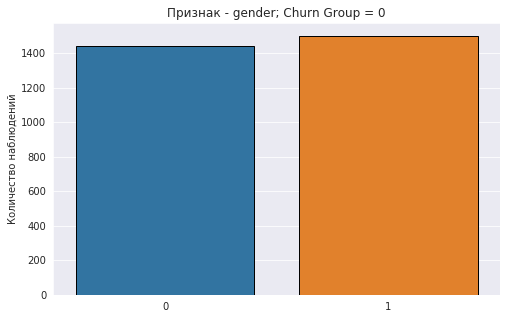

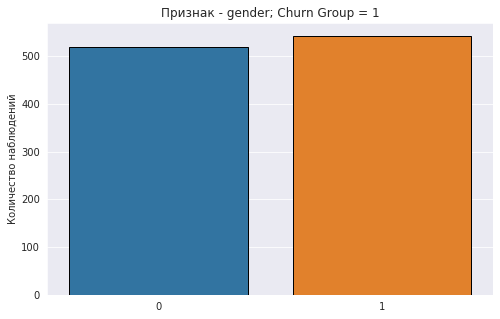

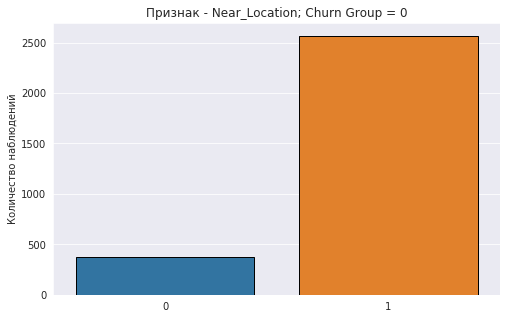

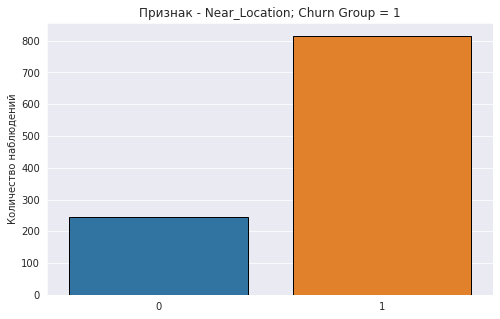

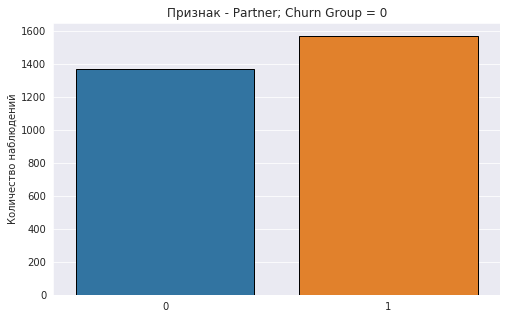

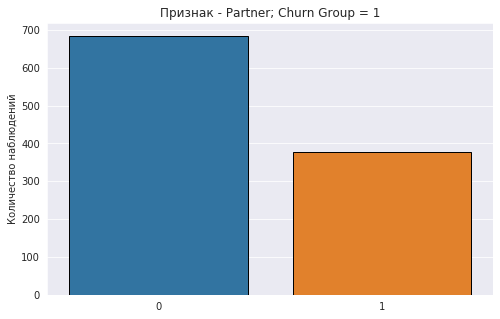

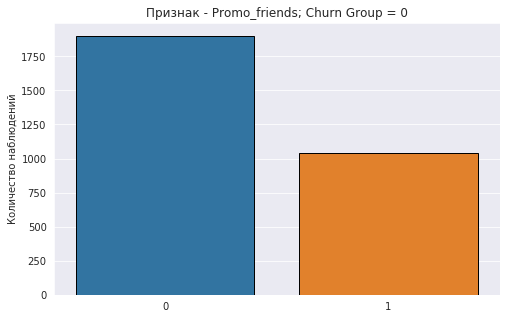

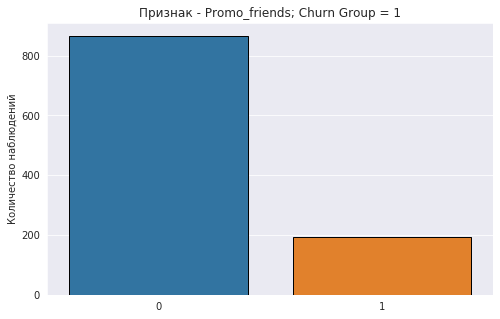

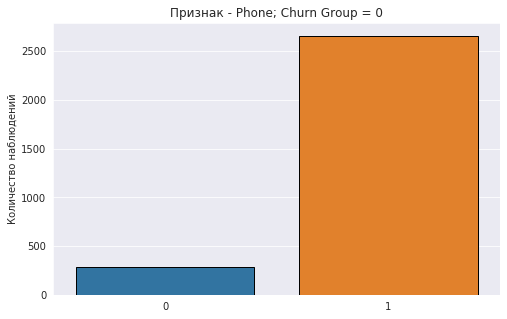

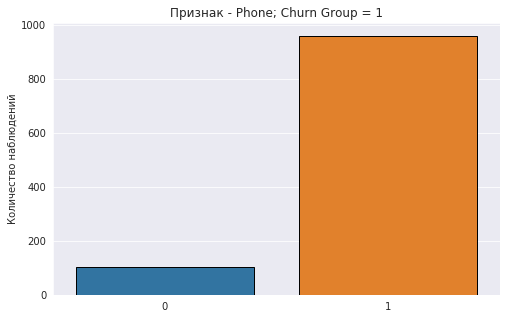

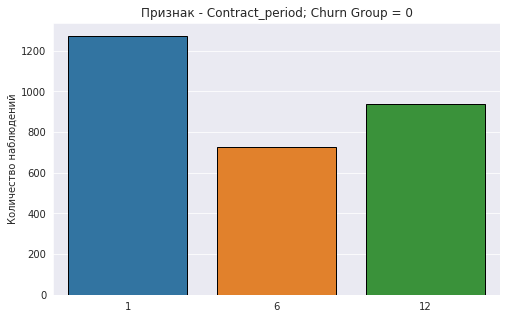

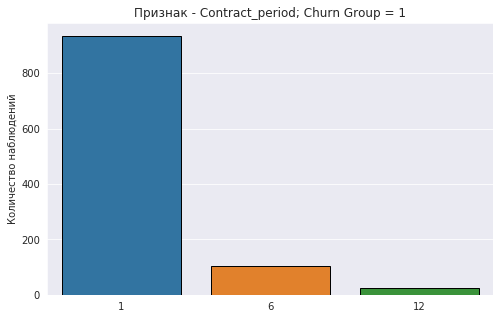

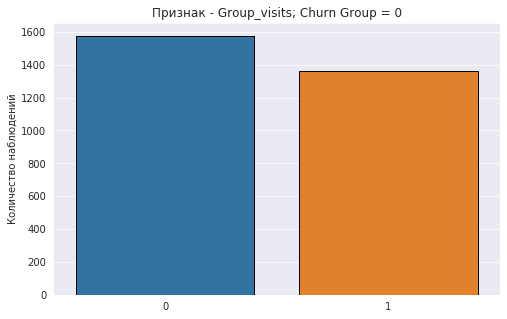

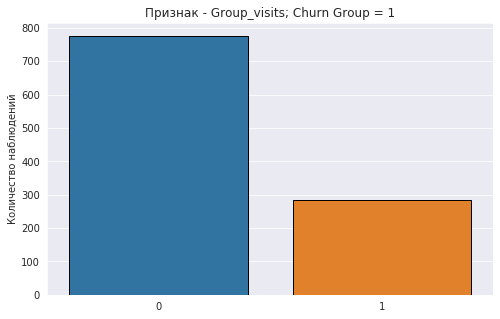

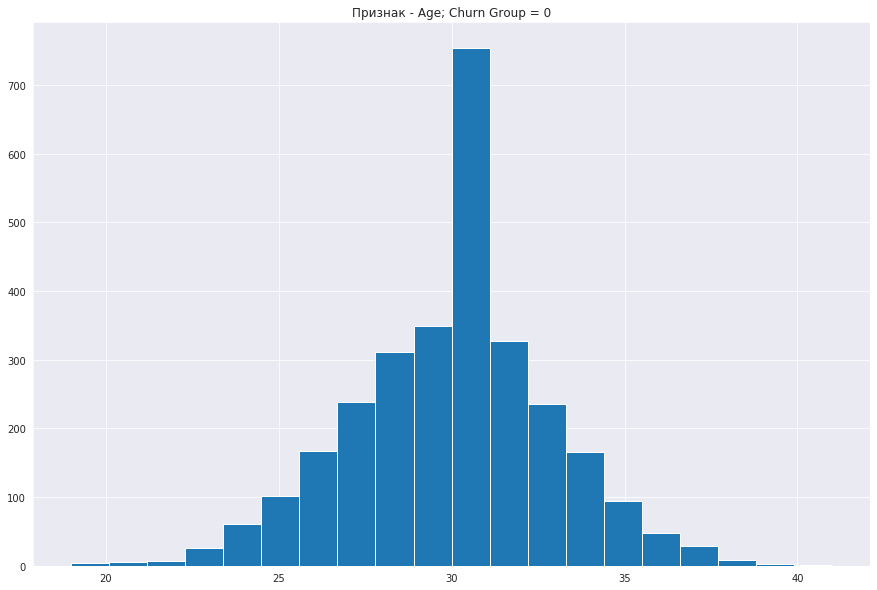

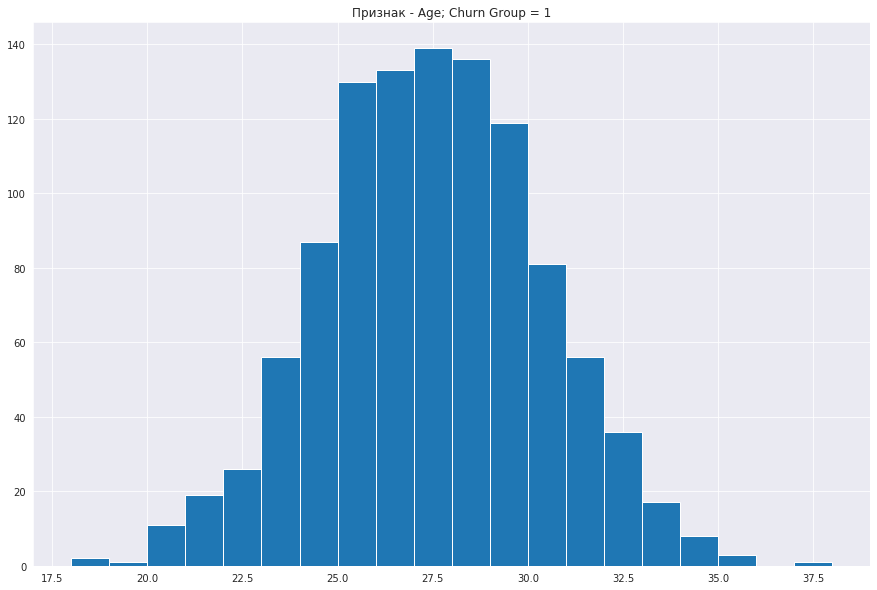

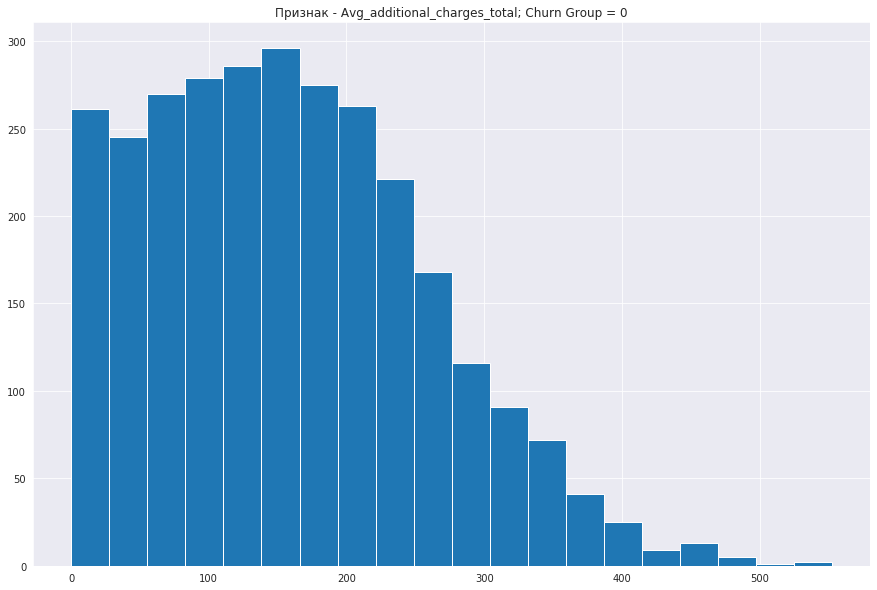

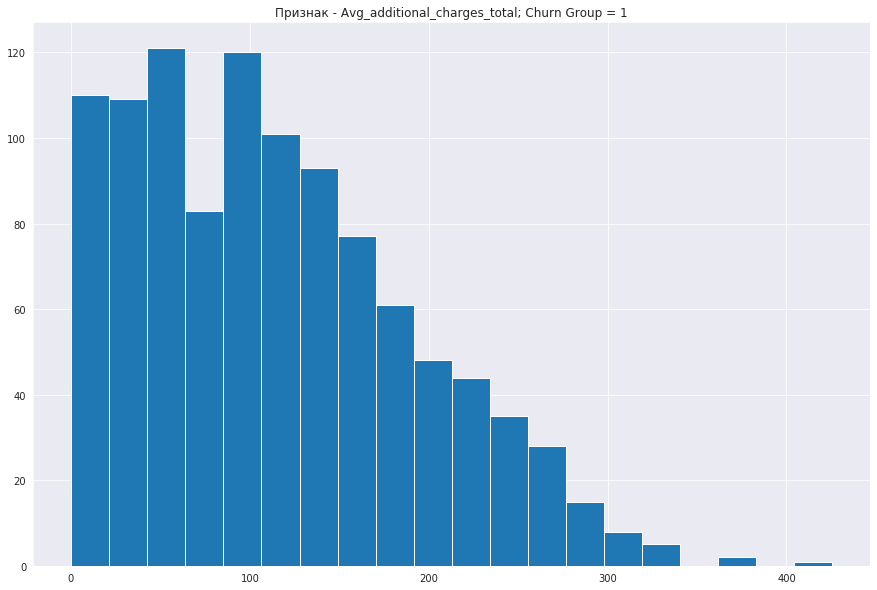

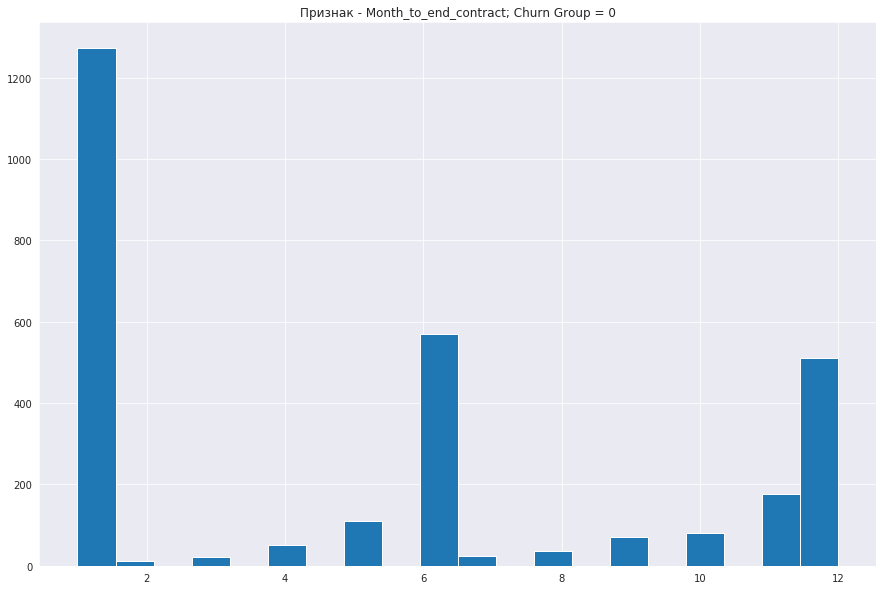

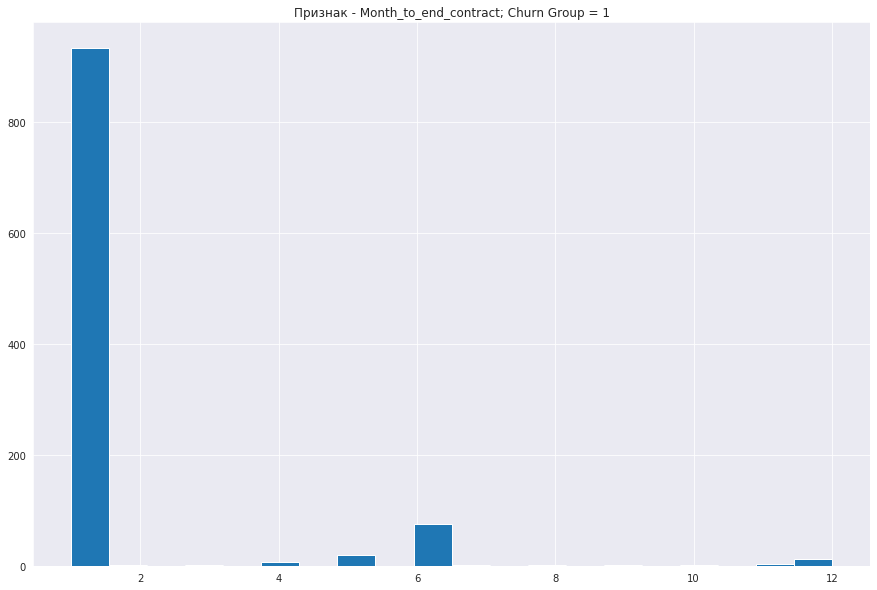

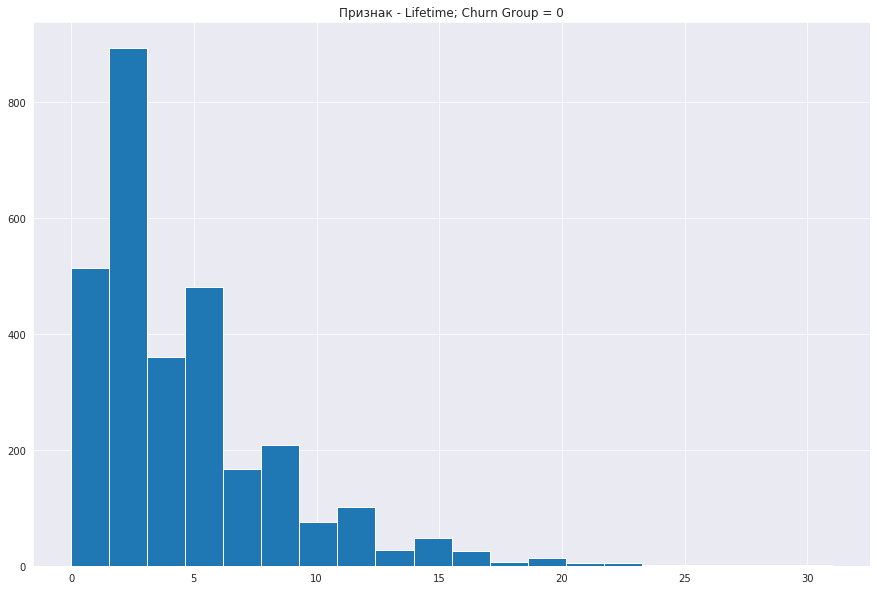

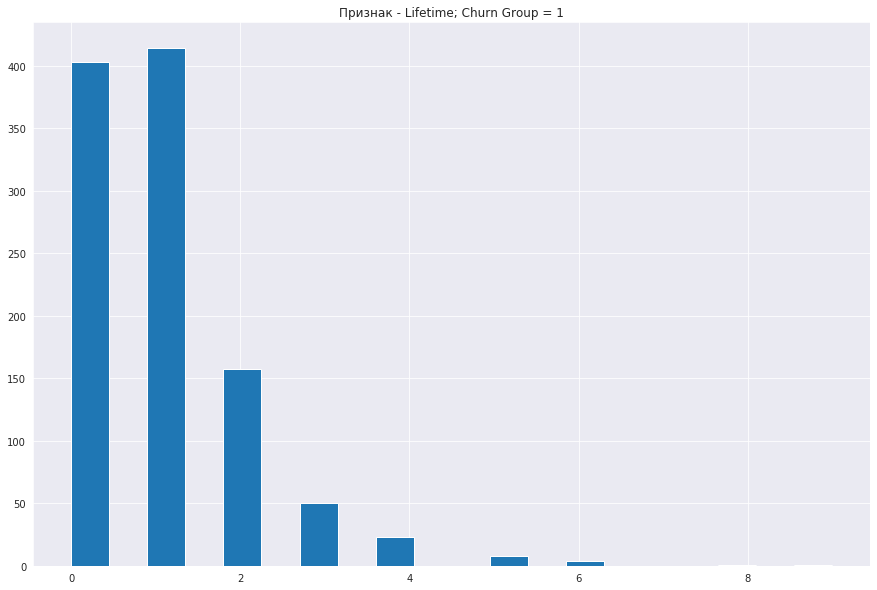

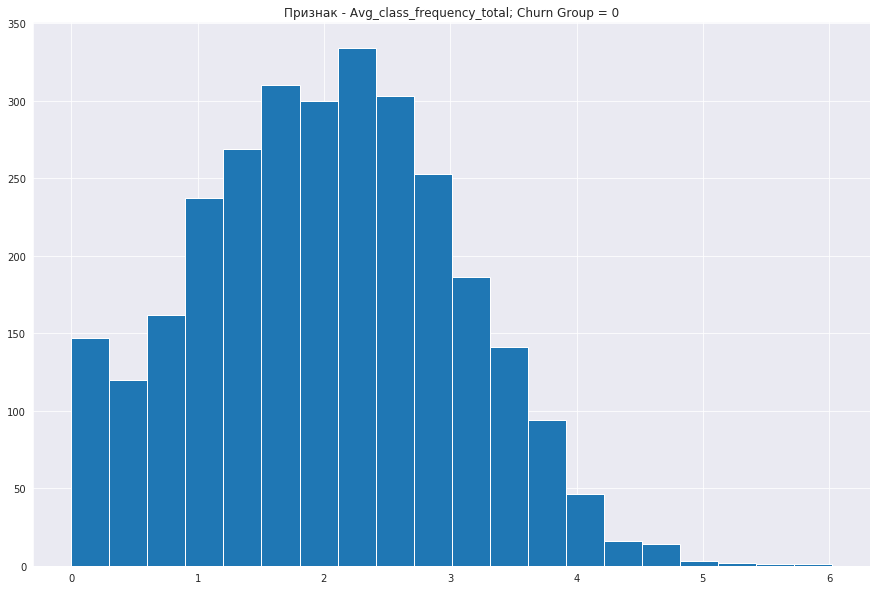

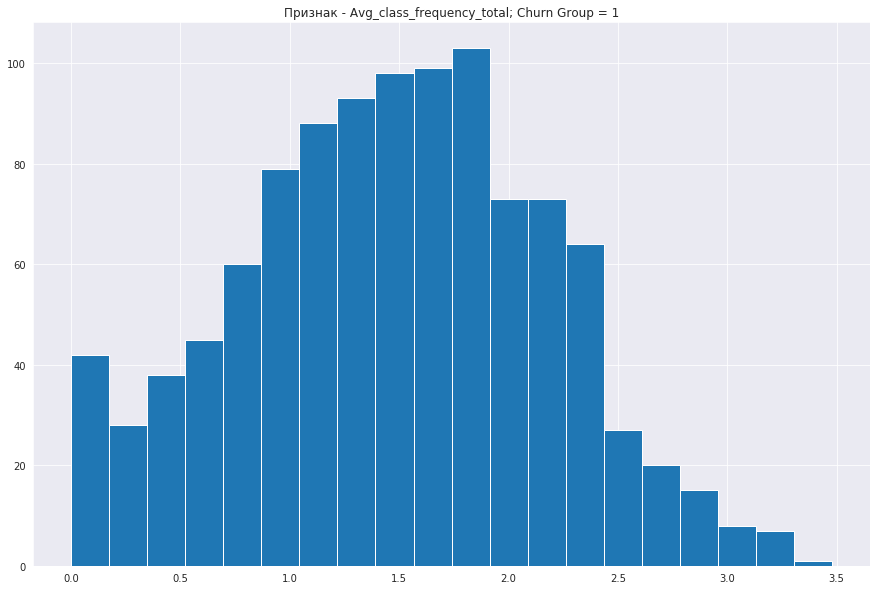

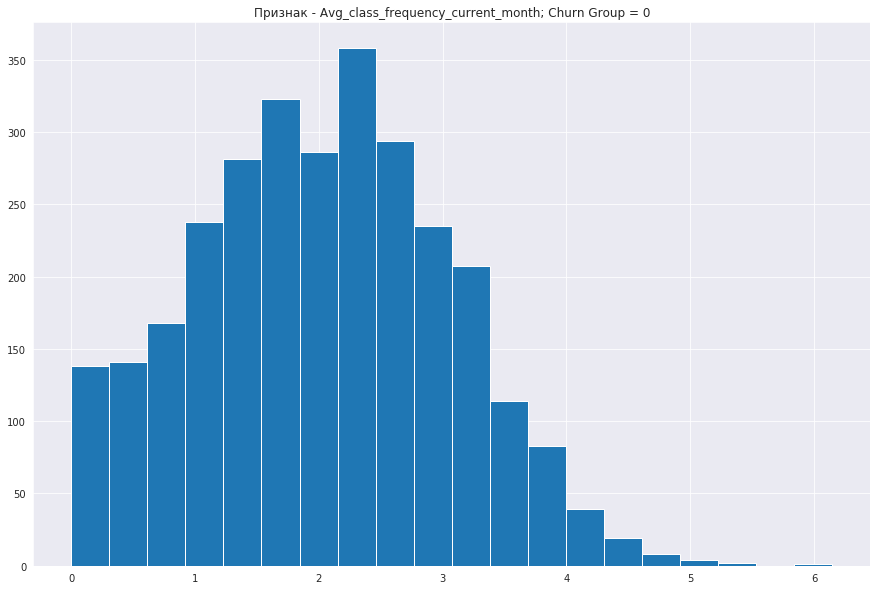

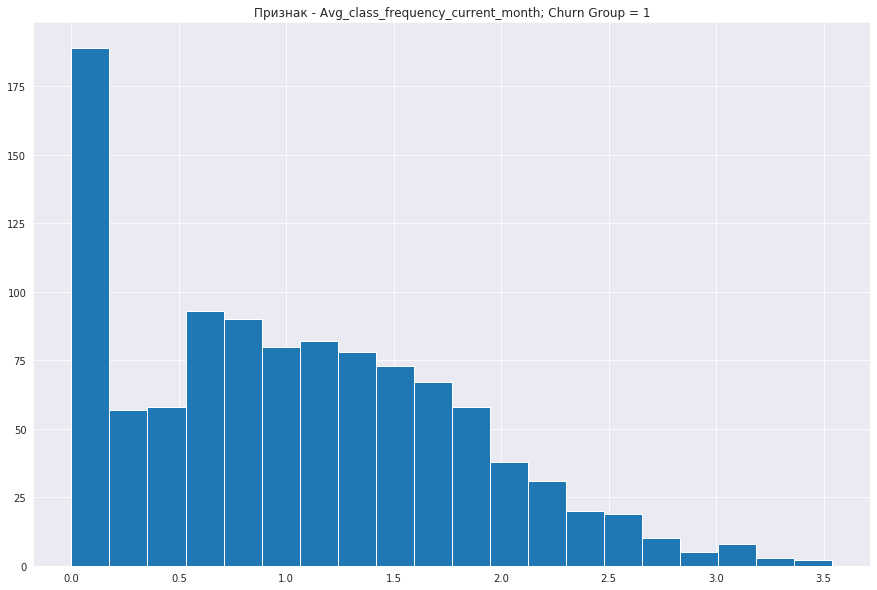

In [12]:
#завернем функцию в цикл и сформируем графики для каждого признака

sns.set_style("darkgrid")

for column in churn_data.columns:
    if column != 'Churn':
        for value in range((churn_data['Churn'].max()) + 1):
            feature = 'Churn'
            feature_trigger = value
            data = churn_data[[column, 'Churn']]
            distribution_graph_drawer(data, feature, feature_trigger, value)

1. Пропорции полов в обеих группах идентичны
2. По признаку  `Near_Location` наблюдается небольшое отличие в пропорциях: в группе уходящих пользователей пропорция пола 0 выше практически вдвое
3. По признаку `Partner` наблюдается довольно значительный перекос в группе уходящих пользователей - наблюдается сниженное количество пользователей партнерских программ от работодателей. Вероятно, это вопрос.
4. Также наблюдается сниженное количество пользователей, пришедших по промо-акции «Приведи друга» в группе уходящих пользователей. Также уходящие пользователи существенно реже (практически вчетверо) пользовались групповыми занятиями
5. Также мы видим подтверждение гипотезы о том, что «уходящие» пользователи изначально предпочитают приобретать абонемент на короткий срок - если у постоянных посетителей абонементы на 6 и 12 месяц - это более половины наблюдений, то противоположной группе эта цифра находится примерно в районе 10-15%
6. Любопытное распределение наблюдается для признака `Age` - в группе постоянных пользователей центр гистограммы в районе 30 лет, в то время как уходящие пользователи немного моложе - визуальный центр распределения в районе 27-28 лет. Кроме того, крайние значения распределения в группе постоянных пользователей смещены вправо. Можем предположить, что более взрослая аудитория склонна быть более лояльной к клубу
7. Постоянные пользователи чаще посещают тренировки 


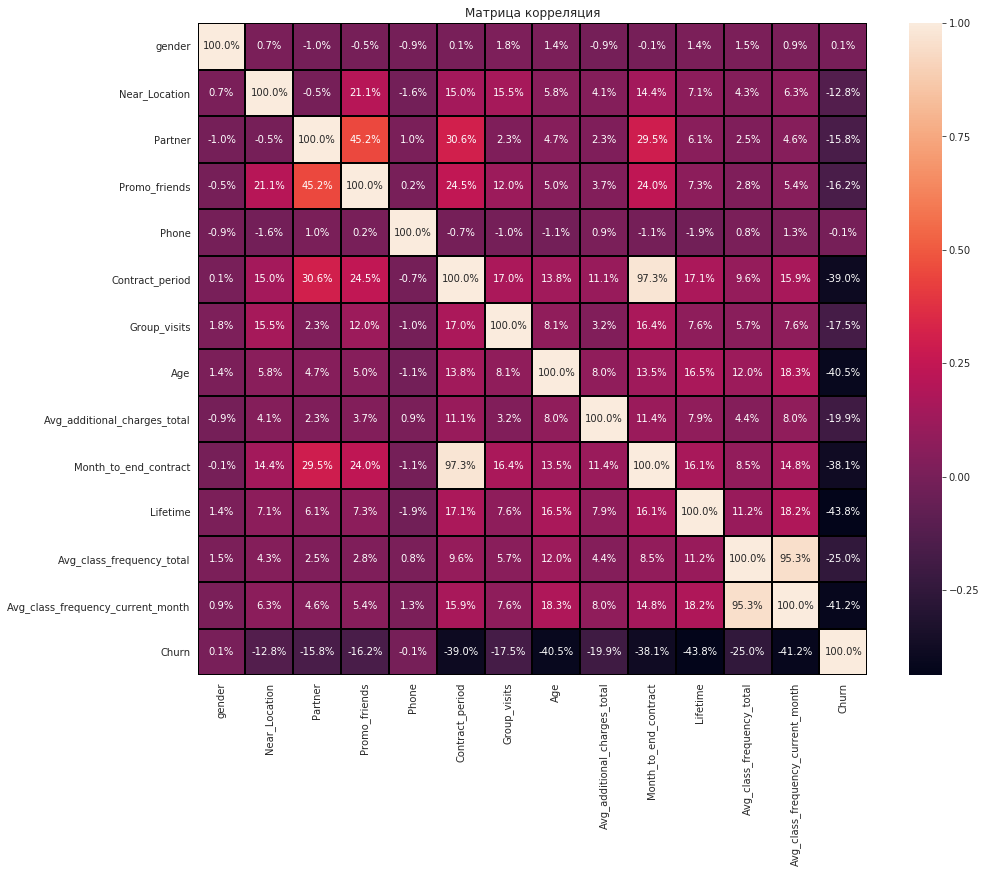

In [14]:
#сформируем визуальную репрезентацию матрицы корреляций
plt.figure(figsize=[15, 12])
plt.title('Матрица корреляция')

sns.heatmap(
    data=corr_matrix,
    annot=True,
    fmt='.1%',
    linewidths=1,
    linecolor='black'
)

plt.show()

1. Между `Contract_period` и `Month_to_end_contract` сильная положительная корреляция (97.3%). Эта взаимосвязь понятна и очевидна - чем длиннее изначальный срок абонемента, тем в среднем больше месяцев до окончания контракта остается у пользователей
2. Сильная положительная корреляция между признаками `Avg_class_frequency_total` и `Avg_class_frequency_current_month` объяснима в первую очередь тем, что эти метрики характризует одно и то же, но за разные периоды (95.3%)
3. Далее мы наблюдаем заметную относительно остальных корреляцию между `Promo_friends` и `Partner` (45.2%). Вероятно, клиенты, пришедшие в клуб по партнерской программе, решили сделать это за компанию со своими коллегами, прислав им некий код или реферальную ссылку
4. Между `Contract_period` и `Partner` наблюдается положительная корреляция (30.6%). Вероятно, предложение для партнеров работает не на все виды абонементов, что сподвигает определенную часть аудитории покупать более длинные абонементы 
5. `Lifetime` и `Churn` наблюдается относительно сильная отрицательная корреляция (-43.8%). Однако предположение о том, что основная часть уходящей аудитории - это новые или относительно новые клиенты, понятно на уровне здравого смысла
6. `Avg_class_frequency_current_month` и `Churn` также показывают относительно сильную обратную корреляцию (-41.2%). Можем предположить, что посещаемость за последний месяц можно использовать в качестве одной из метрик для прогнозирования вероятности оттока клиента. Можно, например, отслеживать посещаемость клиента в текущем месяце и сравнивать ее с общей средней посещаемостью клиента или некими рефернсными значениями группы и контактировать с клиентом на упреждение
7. Также на уровене -40% корреляция между `Age`/`Contract_period` и `Churn`. Чем старше клиент и чем длинее его абонемент, тем меньше вероятность его ухода из клуба

# Модель прогнозирования оттока клиентов

## Логистическая регрессия

In [15]:
churn_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [16]:
#для начала разделим наш датасет на две части: признаки и целевую переменную
X = churn_data.drop('Churn', axis = 1)
y = churn_data['Churn']

#а теперь сформируем обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [17]:
#создаем объект модели
model = LogisticRegression(solver='liblinear')

In [18]:
#обучаем модель на тренировочных данных
model = model.fit(X_train, y_train)

In [19]:
#теперь спрогнозируем 
predictions = model.predict(X_test)

In [20]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.89
Recall: 0.84
F1: 0.87


1. Мы видим, что доля правильных ответов для модели на базе логистической регрессии - 93%, что кажется довольно неплохим результатом
2. Однако доля правильных ответов в целевом классе на уровне 89%, что уже не так положительно характеризует нашу модель
3. Всего 84% реальных объектов удалось обнаружить
4. Сводная метрика F1 на уровне 87%

## Дерево решений/случайный лес

In [21]:
#формируем модель на базе алгоритма дерева решений
tree_model = DecisionTreeClassifier(random_state=0)

In [22]:
#обучим модель на ранее сформированных выборках
tree_model = tree_model.fit(X_train, y_train)

In [23]:
#сделаем прогноз
tree_predictions = tree_model.predict(X_test)

In [24]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predictions)))

Accuracy: 0.89
Precision: 0.78
Recall: 0.80
F1: 0.79


In [25]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=0)

In [26]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [27]:
rf_predictions = rf_model.predict(X_test)

In [28]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.93
Precision: 0.88
Recall: 0.83
F1: 0.86


Мы видим, что метрики для дерева решений показывают эффективность алгоритма ниже таковой для логистической регрессии. Таким образом, в данном кейсе оптимально использовать логистическую регрессию как механизм прогнозирования оттока клиентов.

Лес деревьев показывает уже более высокие метрики, но все еще чуть-чуть не дотягивает до логистической регрессии. 

## Оценка коэффициентов

Так как нам необходимо сфорировать рекомендации по усовершенствованию стратегии удержания клиентов и, как следствие, увеличению числа постоянных пользователей, разумным представляется определить, какие признаки в наибольшей степени влияют на вероятность ухода клиента.

Для оценци этих признаков нам потребуется получить значения весов для каждого из признаков, что в своб очередь требует стандартизации всех значений. 

In [29]:
#формируем новый объект Scaler при помощи которого стандартизируем выборки с признаками
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [30]:
#обучаем алгоритм стандартазиции
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [31]:
#снова обучим модель на базе алгоритма логистической регрессии
model = model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

In [32]:
#далее сформируем датафрейм, куда запишем наименования признаков и соответствующие коэффициенты из уравнения модели
features = pd.DataFrame({'feature': X.columns, 'coeff': model.coef_[0]})
#для наглядности при визуальной оценки важности 
features['abs'] =  [abs(i) for i in features['coeff']]

In [33]:
#выведем таблицу весов признаков обученной модели и отсортируем по убыванию модуля веса 
features.sort_values(by='abs', ascending=False)

,feature,coeff,abs
12,Avg_class_frequency_current_month,-4.189012,4.189012
10,Lifetime,-3.471939,3.471939
11,Avg_class_frequency_total,3.105587,3.105587
7,Age,-1.148928,1.148928
5,Contract_period,-0.687710,0.687710
9,Month_to_end_contract,-0.617235,0.617235
8,Avg_additional_charges_total,-0.560866,0.560866
6,Group_visits,-0.393328,0.393328
3,Promo_friends,-0.139599,0.139599
2,Partner,-0.068231,0.068231


1. Самое большой вес у признака `Avg_class_frequency_current_month`. То есть, среднее количество посещений оказывает наибольшее влияние на вероятность ухода клиента. При этом, зависимость обратно пропорциональна - другими словами, чем ниже количество занятий в текущем месяце, тем выше вероятность, что этот клиент покинет клуб.
2. Любопытно, что похожий признак `Avg_class_frequency_total` также имеет большой вес (3е место), но в данном случае зависимость прямо пропорциональна.
3. 2е место по значению занимает вес признака `Lifetime` 
4. Втрое ниже вес у признака возраста, но очевидно, что он также имеет высокое значение 

## Кластеризация клиентов

In [34]:
#сформируем сет со стандартизированными значениями признаков для расчета расстояний между наблюдениями
X_sc = scaler.fit_transform(X)

In [35]:
linked = linkage(X_sc, method = 'ward') 

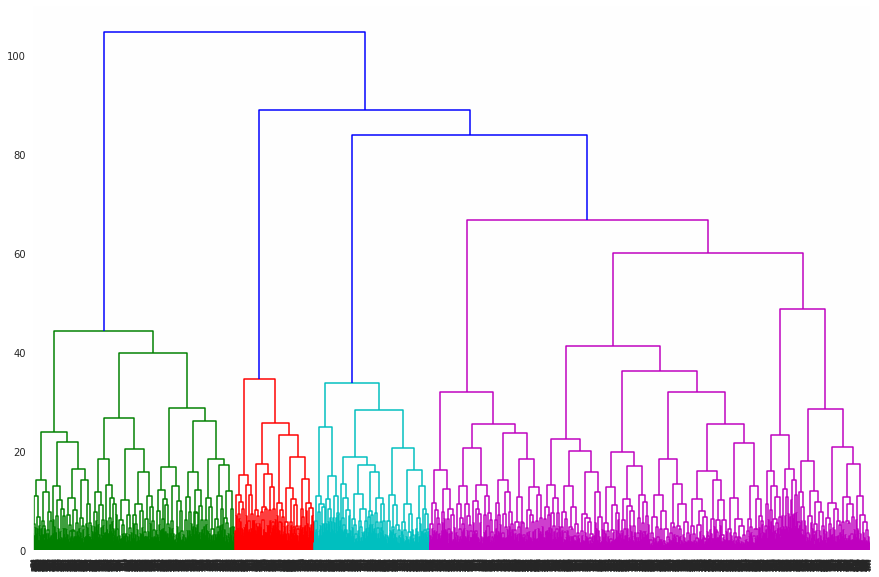

In [36]:
#рисуем дендрограмму для определения предполагаемого количества кластеров и использования этого значения
#в алгоритме k-means
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Предположительно, мы можем выделить 4 кластера. 

In [37]:
#формируем объект на базе алгоритма кластеризации k-means и задаем число кластеров, которое мы увидели на 
#дендрограмме (на самом деле то, которое указано в задании)
km = KMeans(n_clusters=5, random_state = 0)

In [38]:
labels = km.fit_predict(churn_data)

In [39]:
churn_data['cluster_km'] = labels

In [40]:
churn_data.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.514091,0.839650,0.451895,0.279883,0.897959,4.301263,0.407191,28.973761,105.932804,3.996113,3.544218,1.852564,1.708264,0.334305
1,0.511435,0.844075,0.495842,0.320166,0.902287,4.755717,0.423077,29.401247,174.873445,4.376299,3.749480,1.895200,1.785569,0.226611
2,0.468635,0.856089,0.516605,0.332103,0.926199,5.822878,0.431734,29.845018,356.481960,5.383764,4.420664,2.019260,2.009382,0.044280
3,0.508721,0.824612,0.488372,0.293605,0.907946,4.198643,0.387597,28.908915,35.600722,3.855620,3.394380,1.836755,1.692641,0.349806
4,0.521246,0.881020,0.511331,0.347025,0.898017,5.400850,0.433428,29.344193,250.984767,5.001416,4.169972,1.903480,1.843255,0.178470


Следующие интересные наблюдения:

1. В одной из групп достигается максимальное среднее значение `Contract_period` - в ней же самое низкое среднее значение оттока. Вероятно, в этот кластер попали максимально лояльные клиенты.
2. Это утверждение подтверждается и средней суммой дополнительных трат в этой группе - она максимальна и примерно на 40% выше следующего по величине значения
3. В целом в 2 из 5 групп попали наиболее лояльные клиенты, но в одной из групп среднее значение коэффициента удержания втрое выше, что говорит о значительно большем количестве уходящих пользователей 
4. Также выделяются две наименее лояльные группы. При этом в одной из них самый большой отток, минимальные затраты на дополнительные услуги и самая низкая посещаемость как в текущем месяце, так и в целом

Построим распределения для признаков в разных выделенных нами кластерах. Для этого воспользуемся ранее подготовленной функцией с небольшими изменениями. 

In [41]:
#напишем функцию, которая нарисует нам распределения признаков 
def distribution_graph_drawer(data, feature, feature_trigger, value):
    bins = 20
    data = data[data[feature] == feature_trigger]
    for feature in data.columns:
        if len(data[feature].unique()) < 4 and feature != 'cluster_km': #для категорийных переменных нарисуем более понятный график
            grouped_df = data.groupby(feature)[feature].count()
            plt.figure(figsize=[8, 5])
            feature_cnt = sns.barplot(
                x=grouped_df.index,
                y=grouped_df.values,
                edgecolor = "black"
            )
            
            feature_cnt.set(
                title=('Признак - ' + feature + '; Cluster = {:.0f}'.format(value)), #вот тут наше изменение - пояснительный текст
                xlabel='',
                ylabel='Количество наблюдений'
            )
            
            plt.show()
        elif len(data[feature].unique()) > 4: #для количественных переменных подойдет классическая гистограмма
            data[feature].hist(bins=bins, figsize=(15, 10))
            plt.title('Признак - ' + feature + '; Cluster = {:.0f}'.format(value))
            plt.show()
        else:
            continue

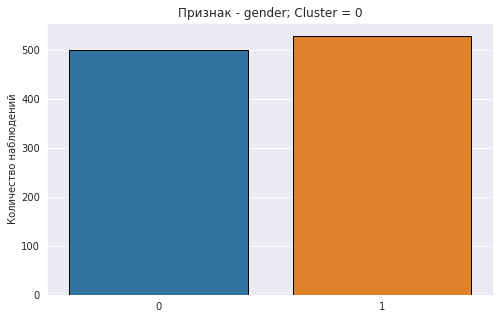

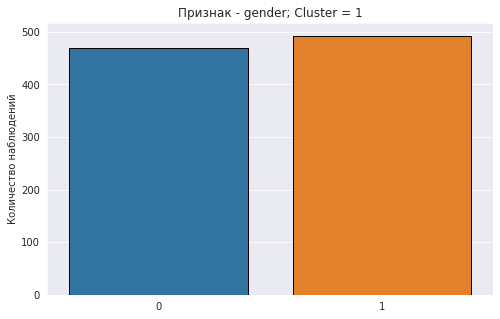

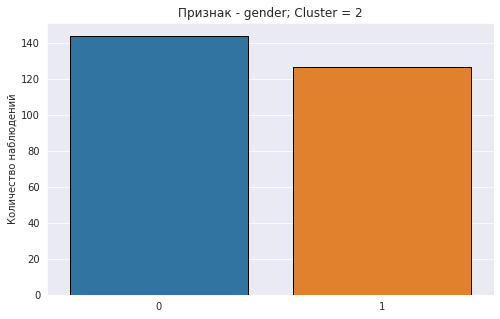

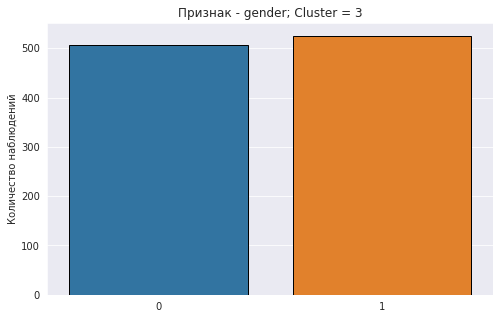

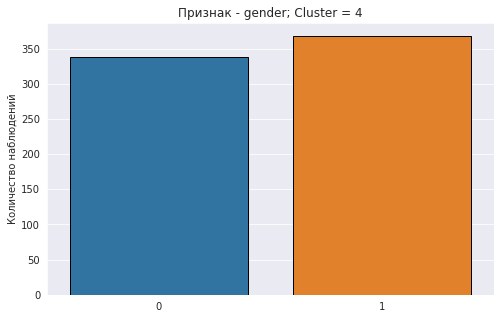

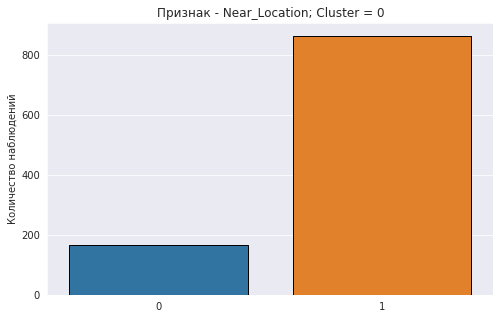

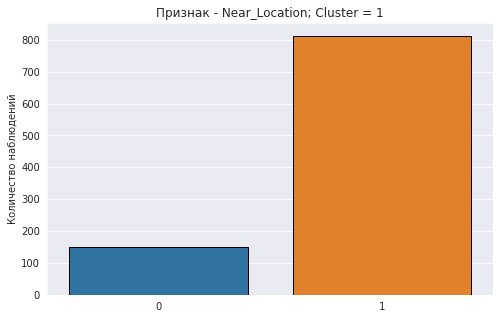

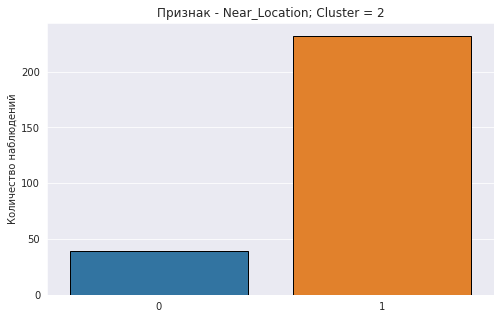

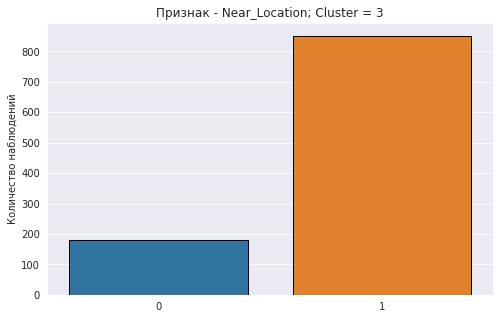

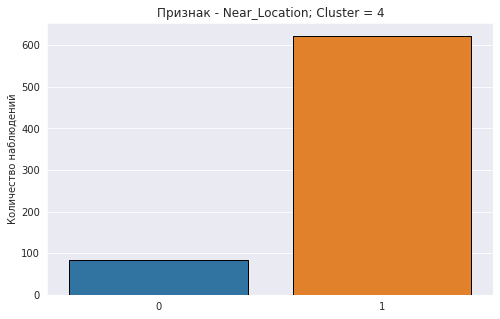

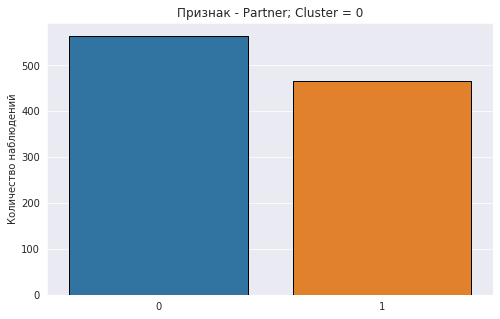

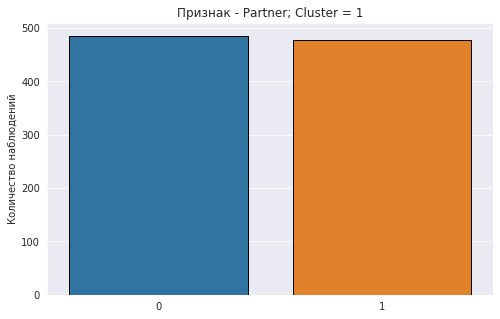

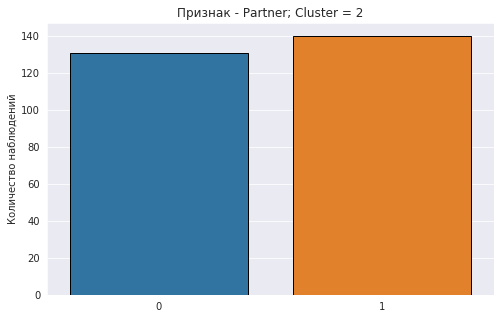

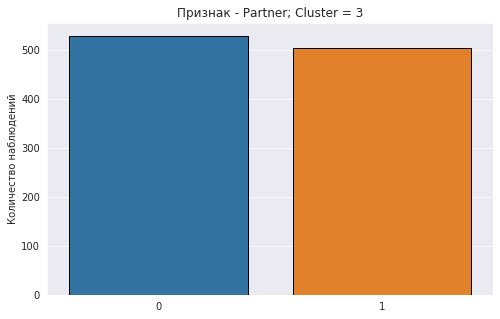

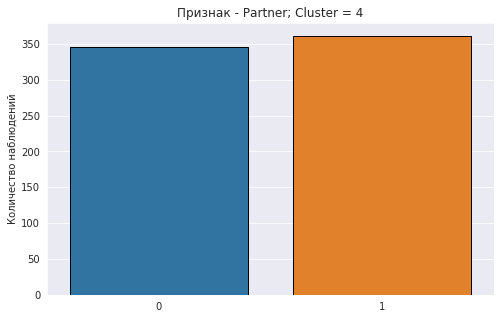

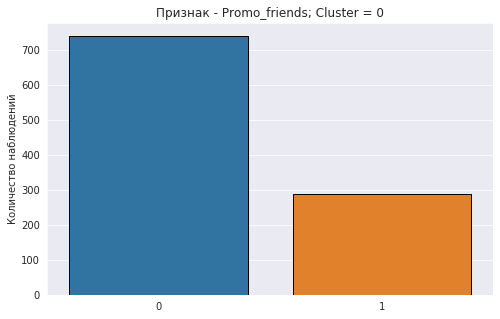

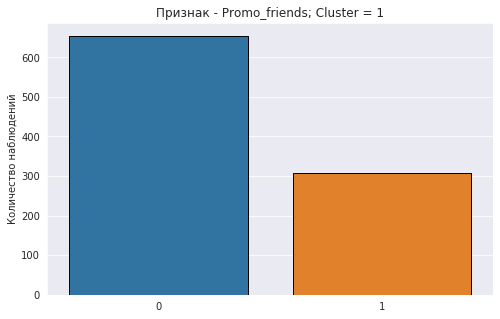

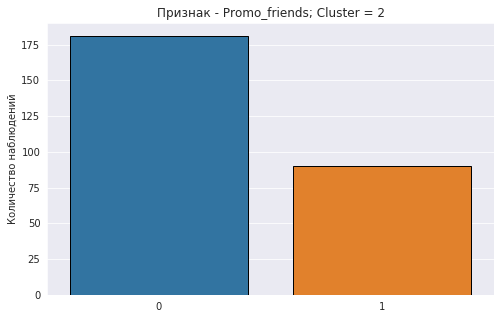

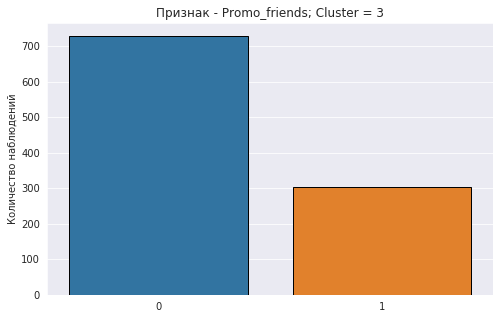

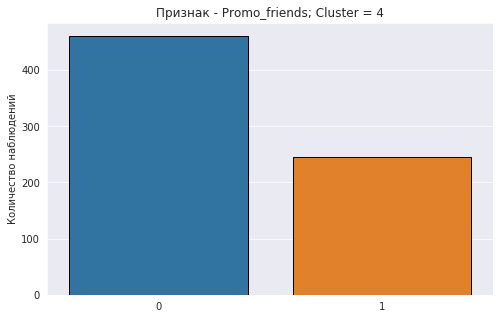

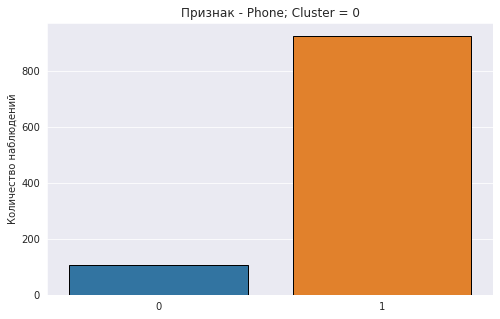

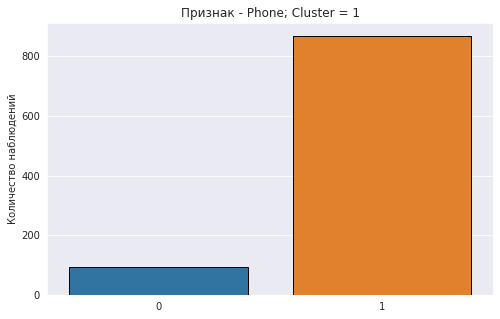

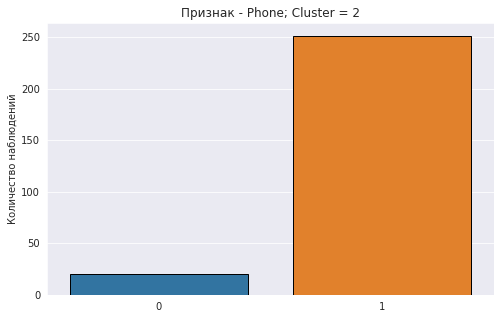

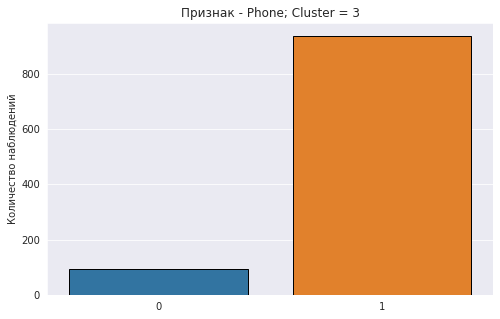

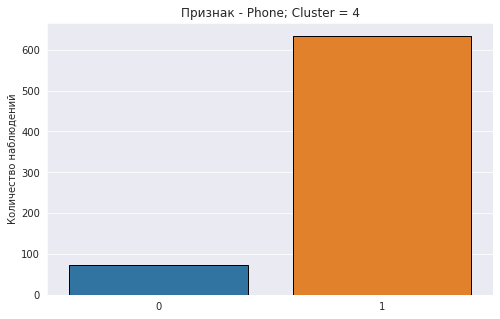

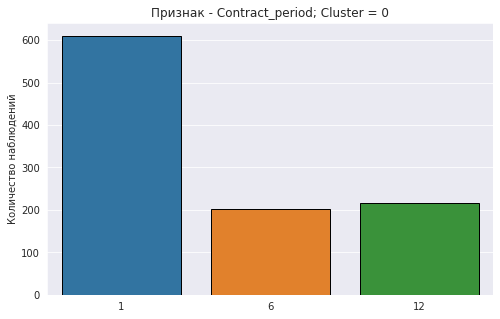

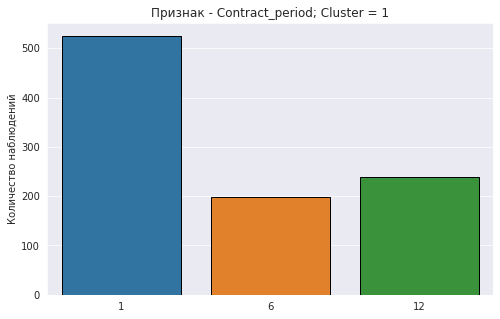

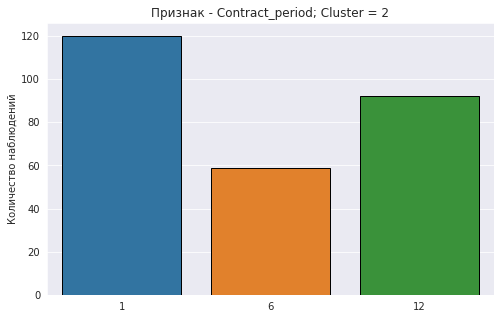

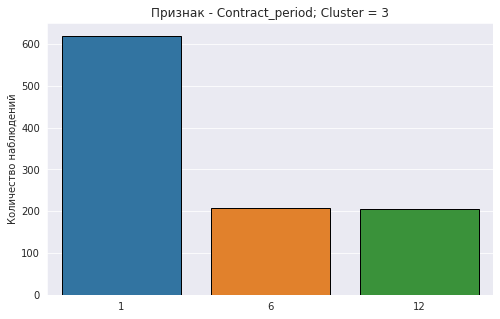

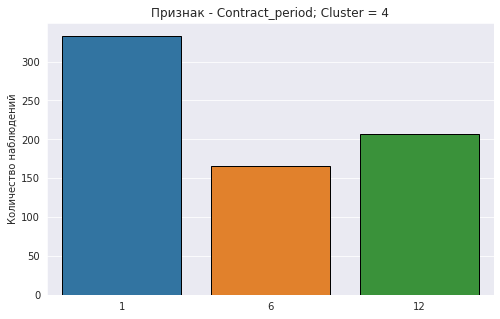

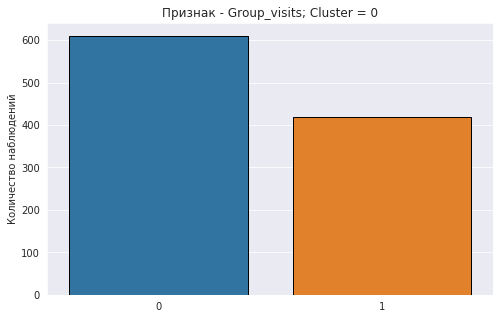

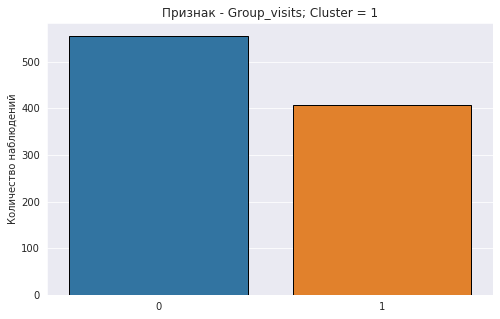

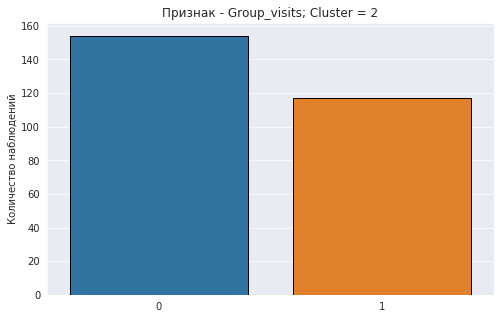

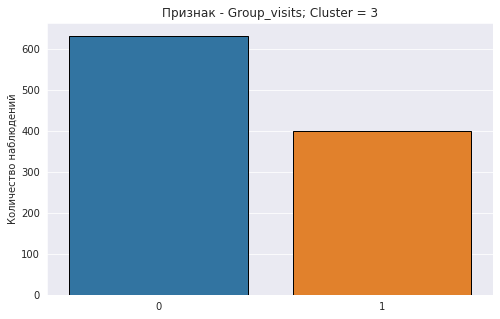

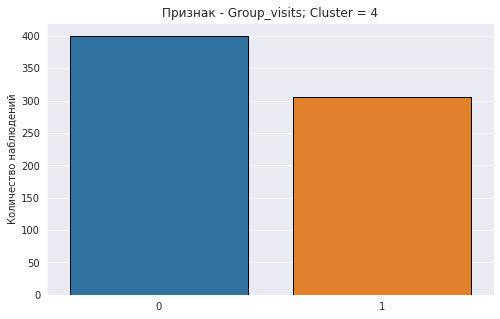

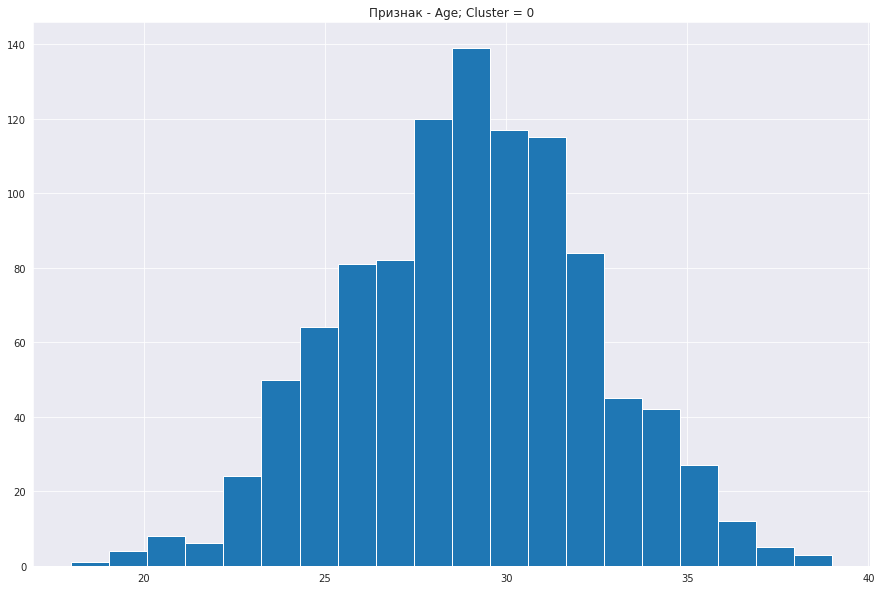

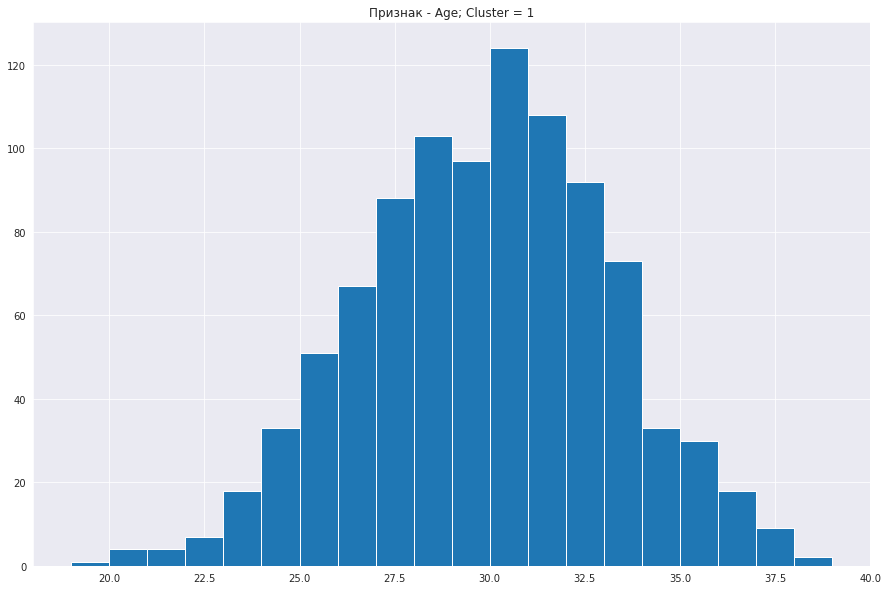

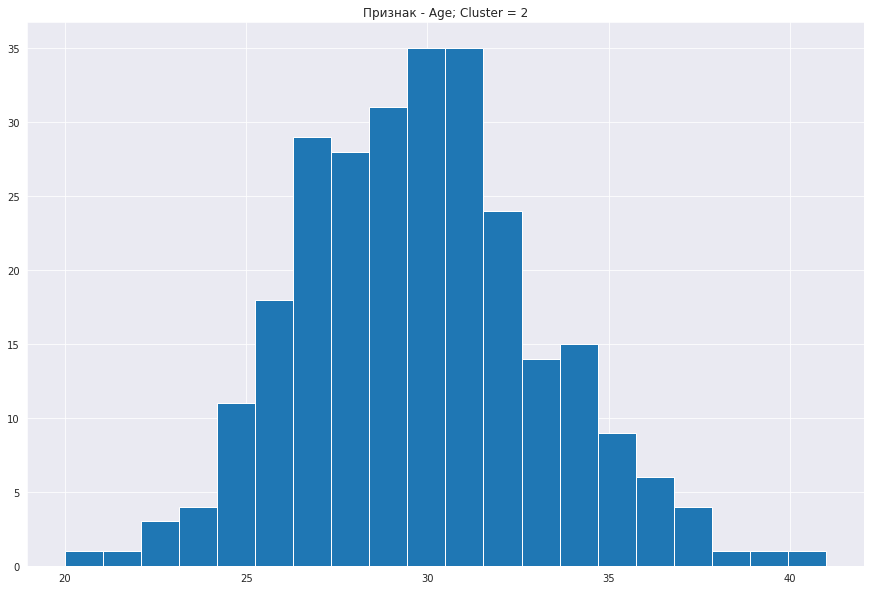

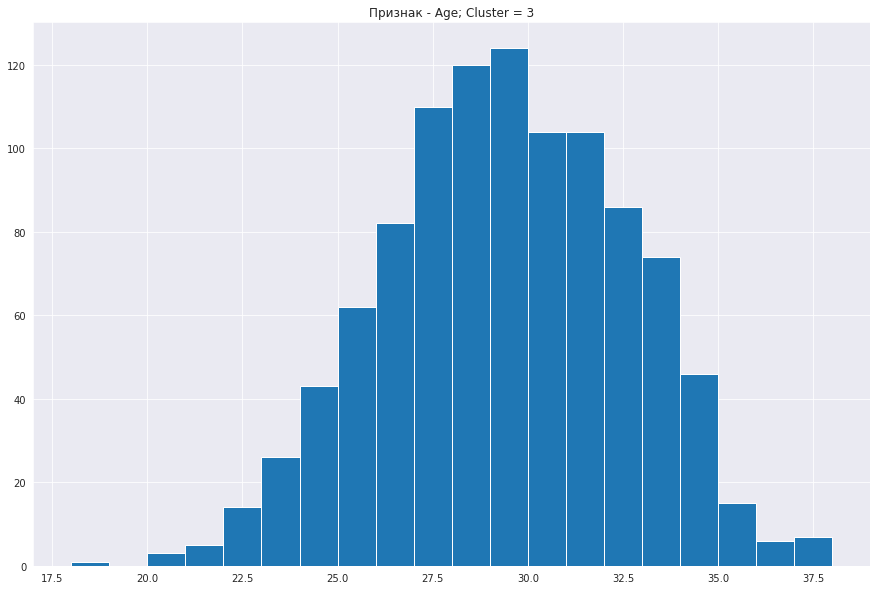

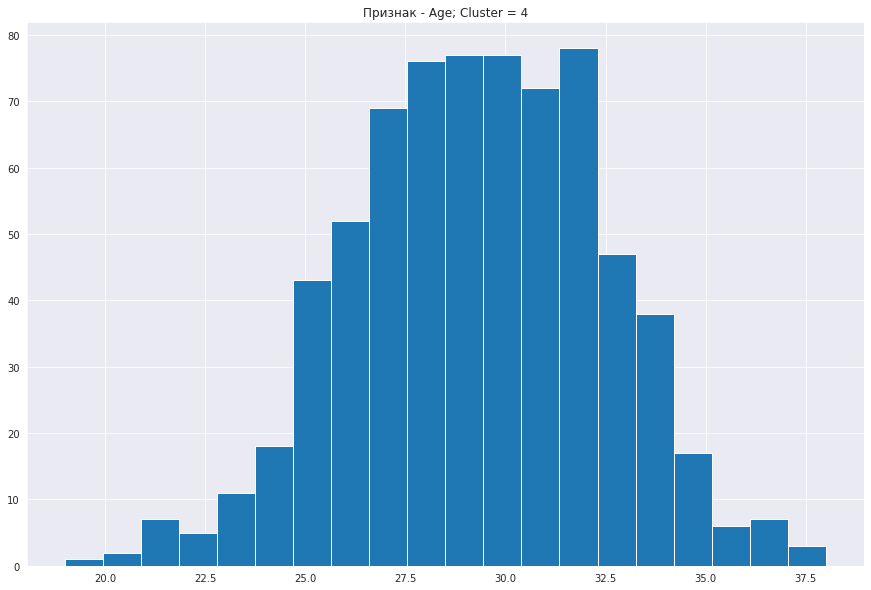

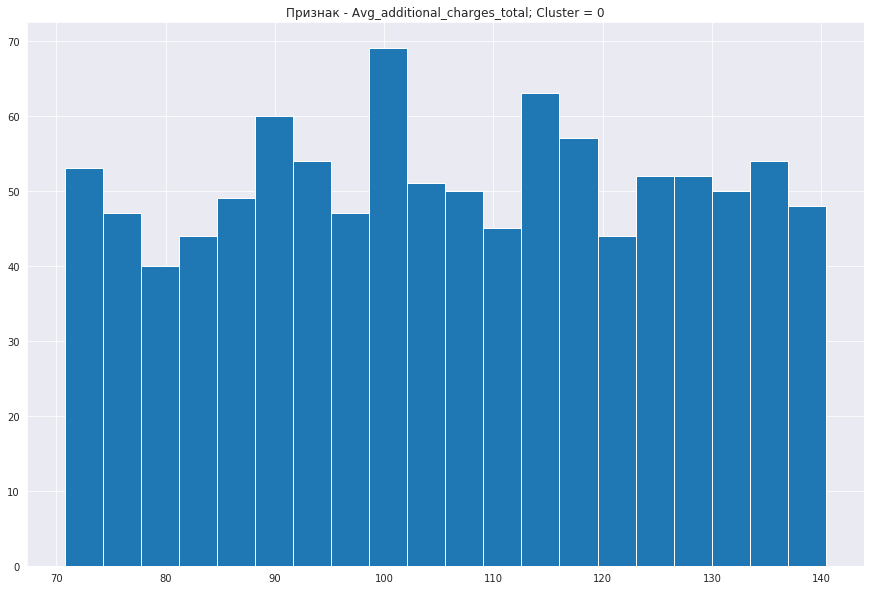

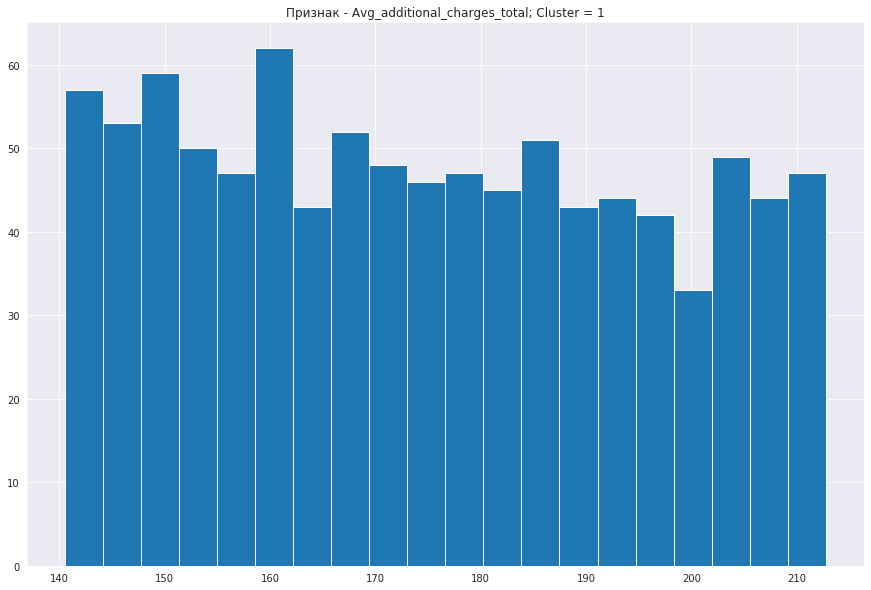

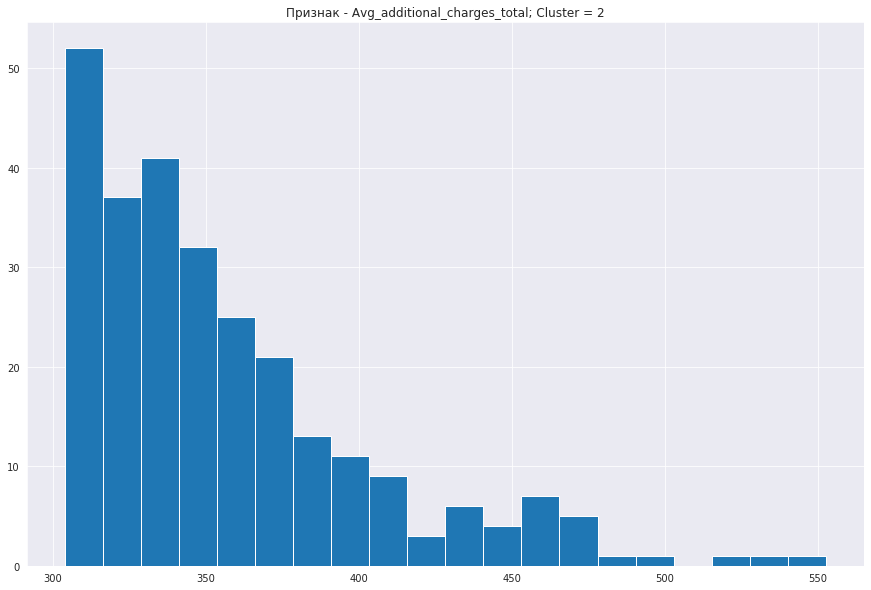

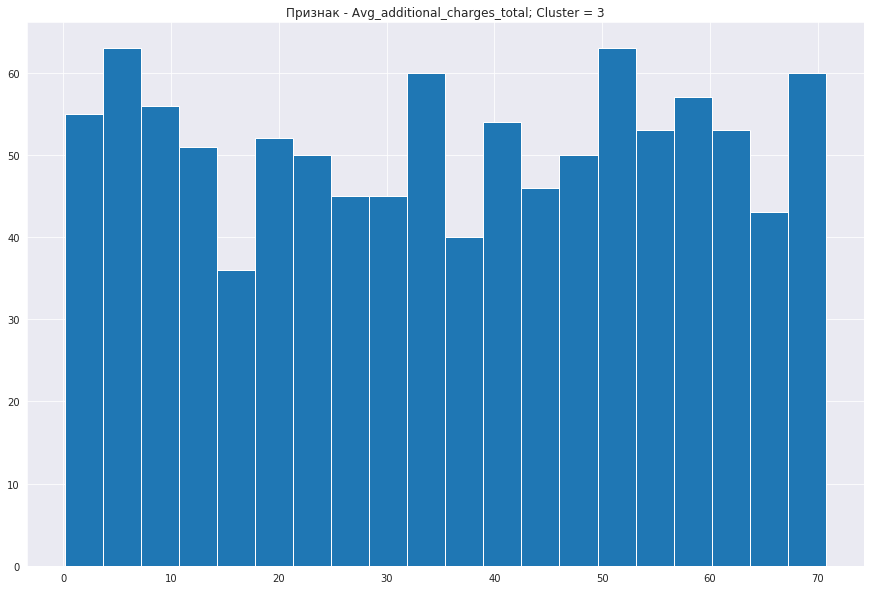

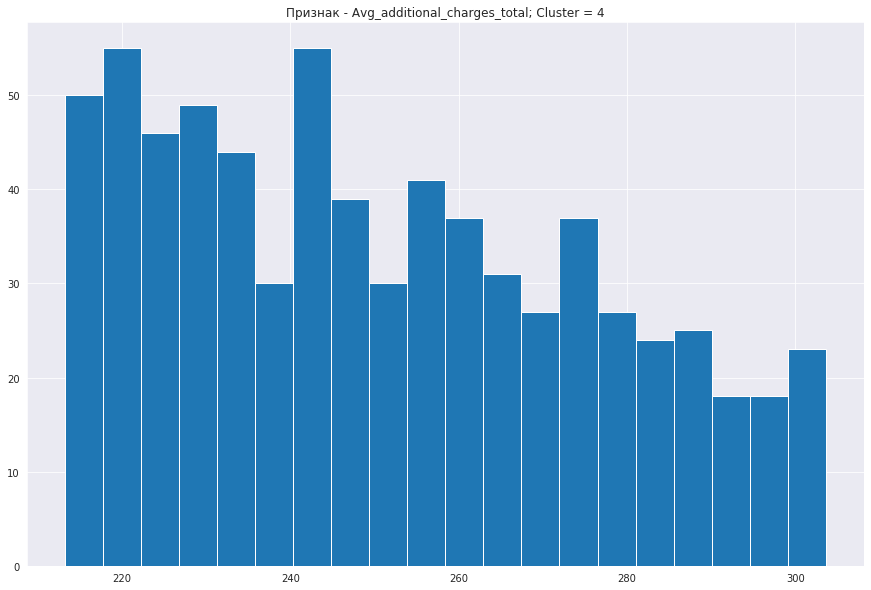

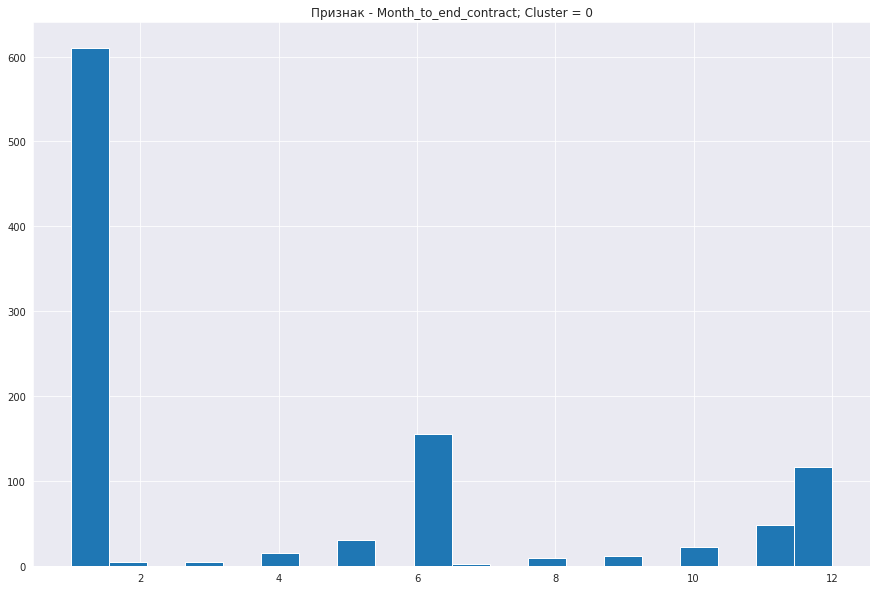

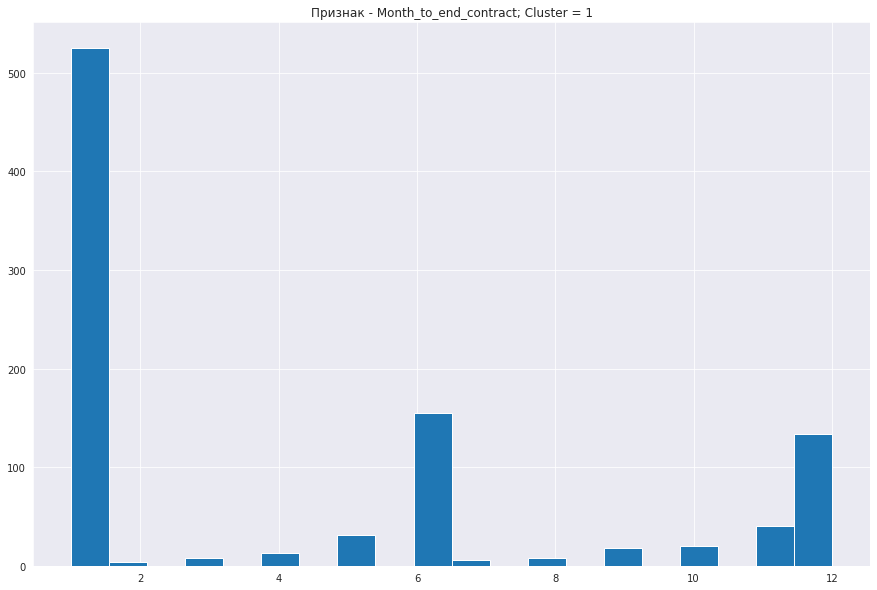

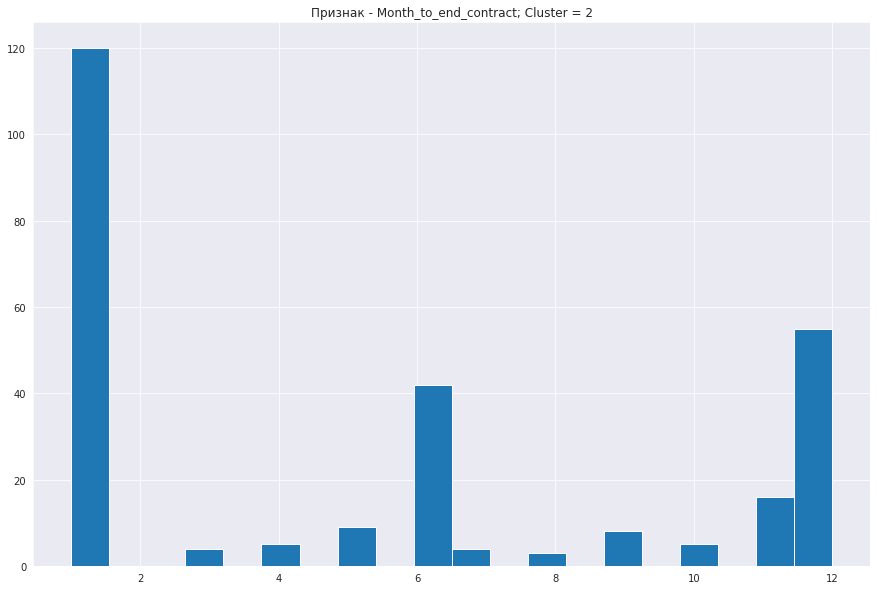

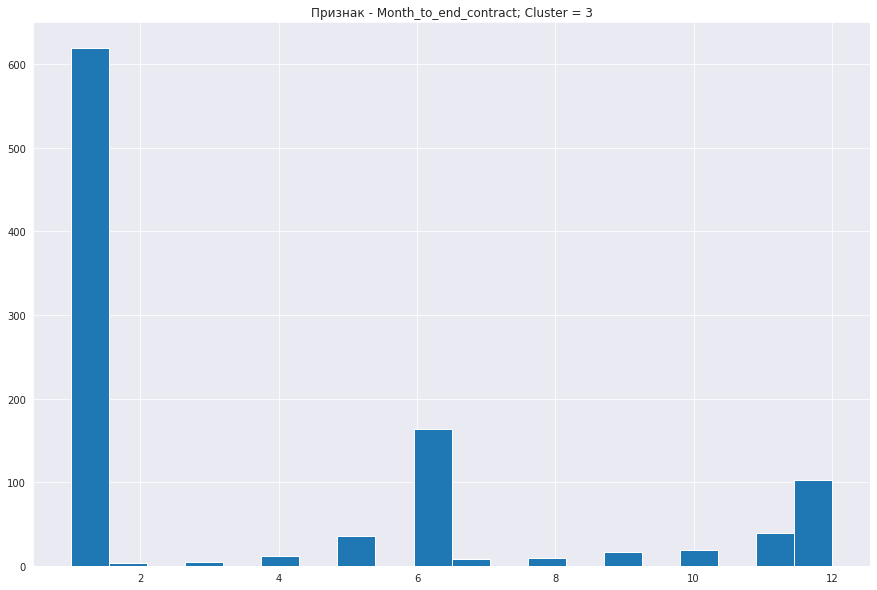

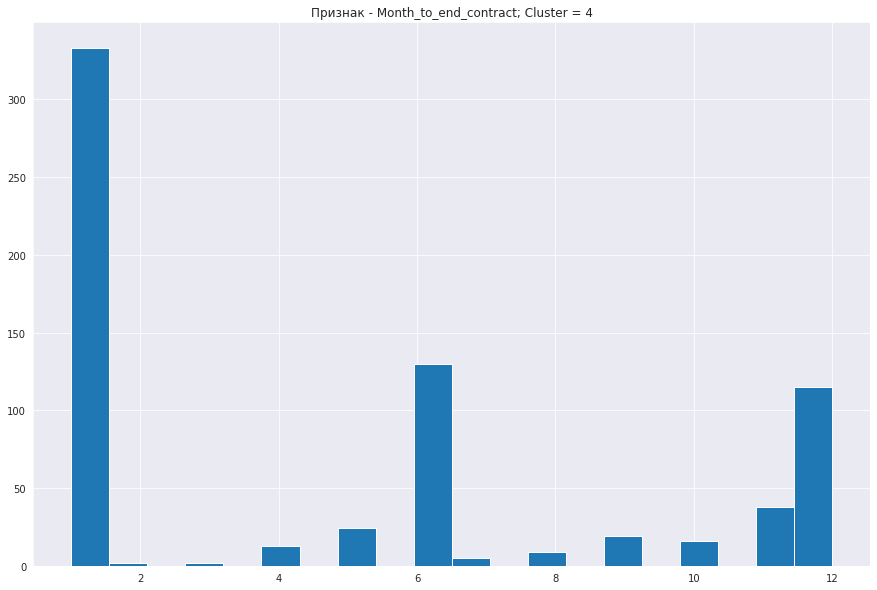

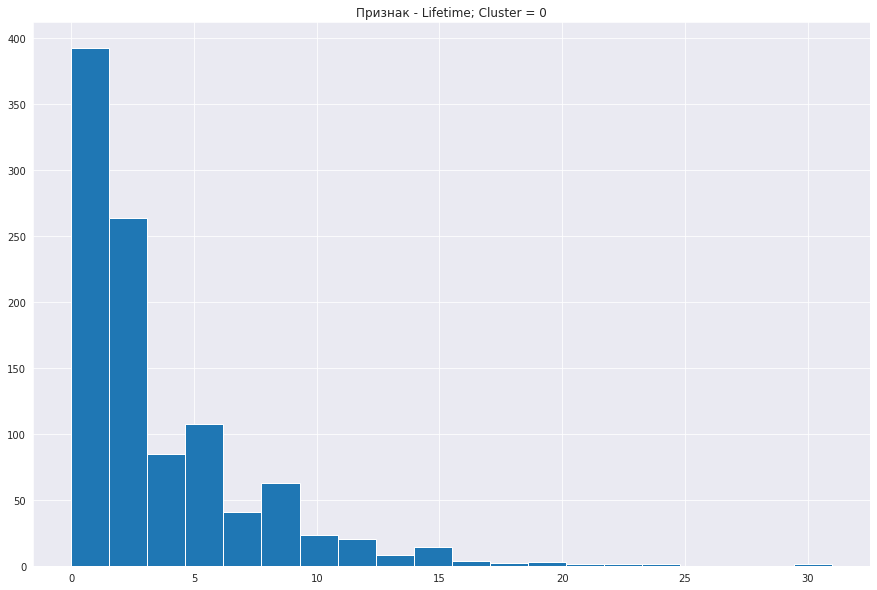

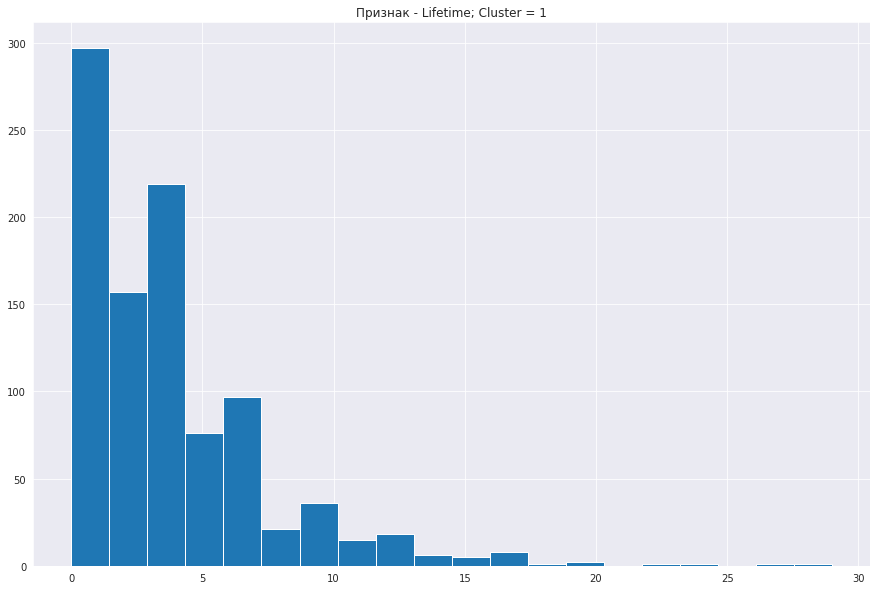

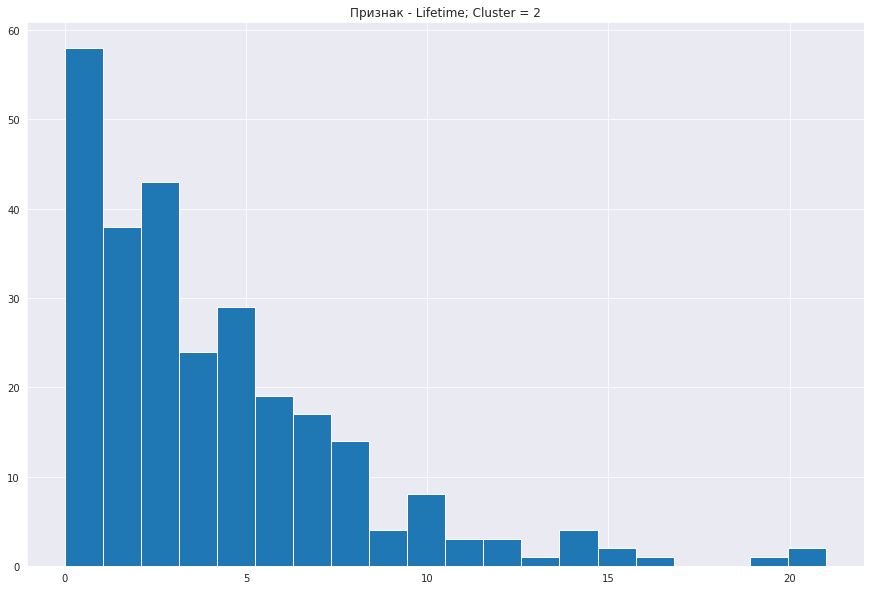

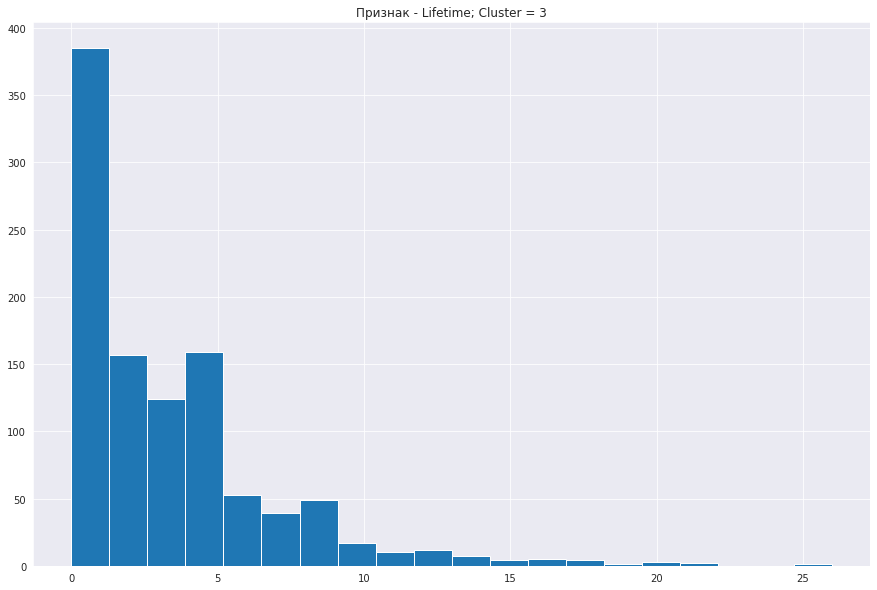

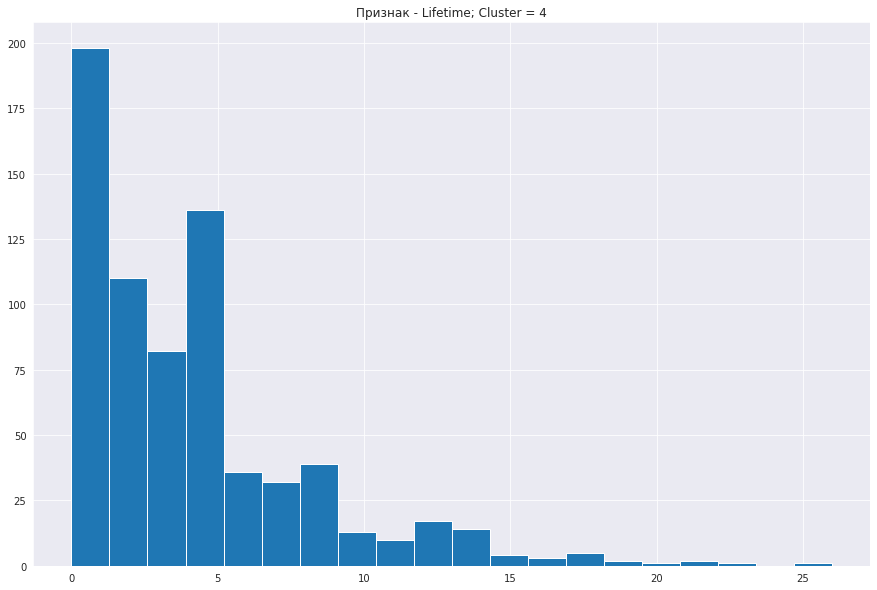

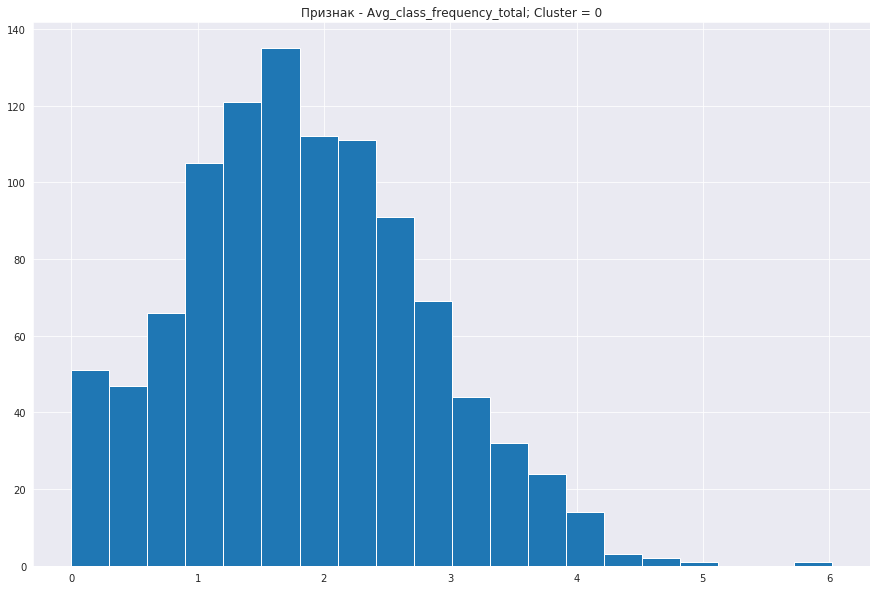

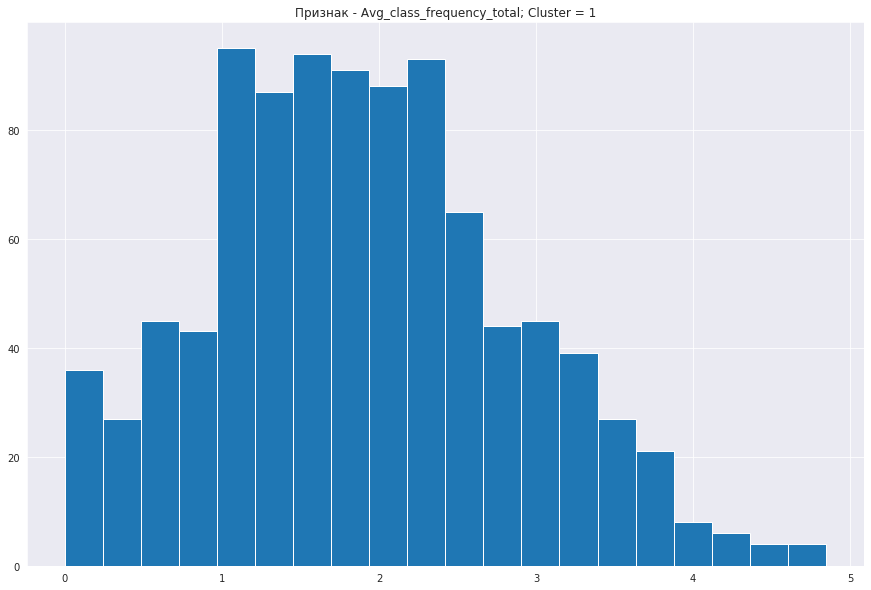

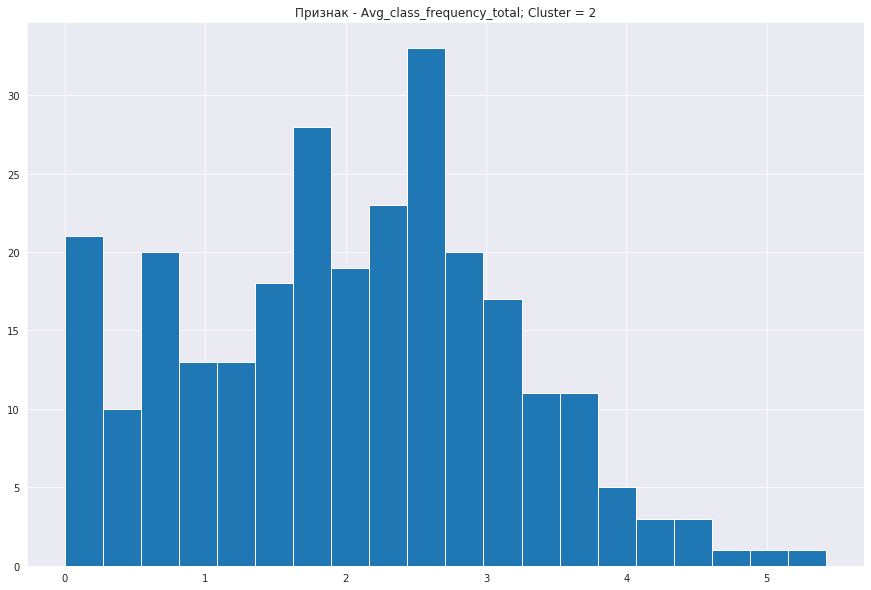

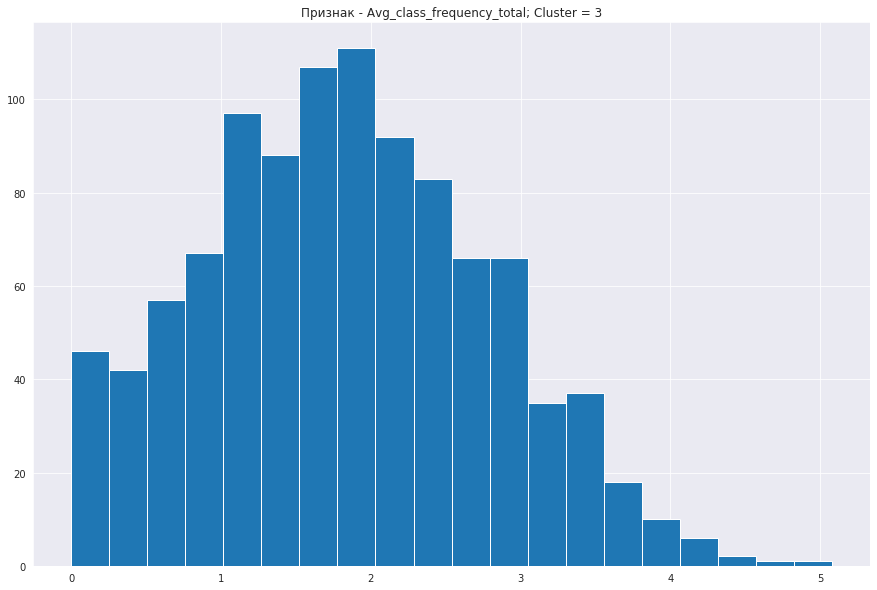

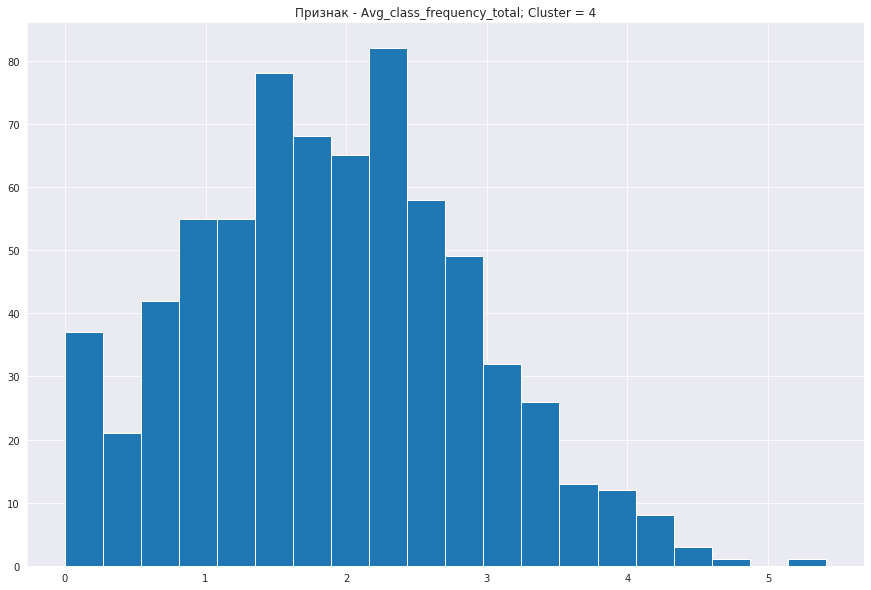

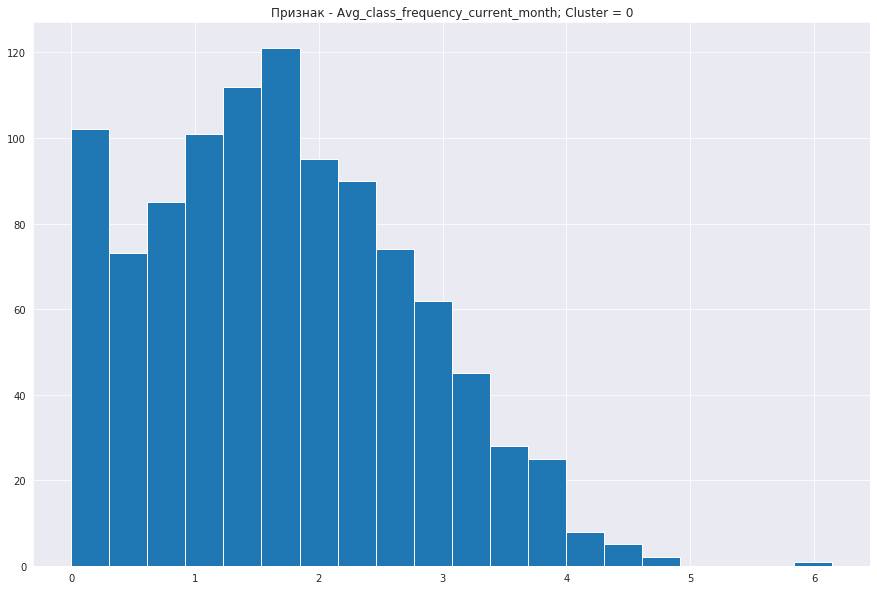

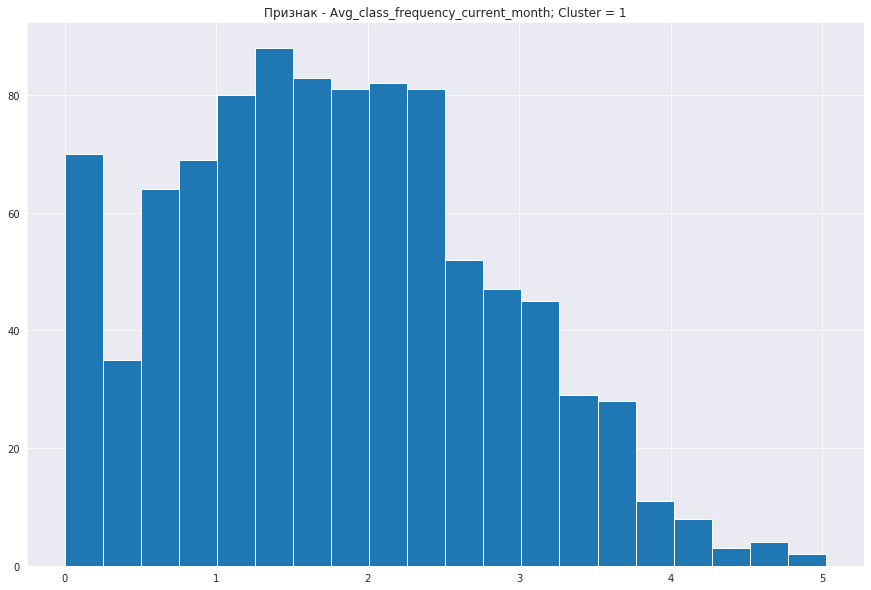

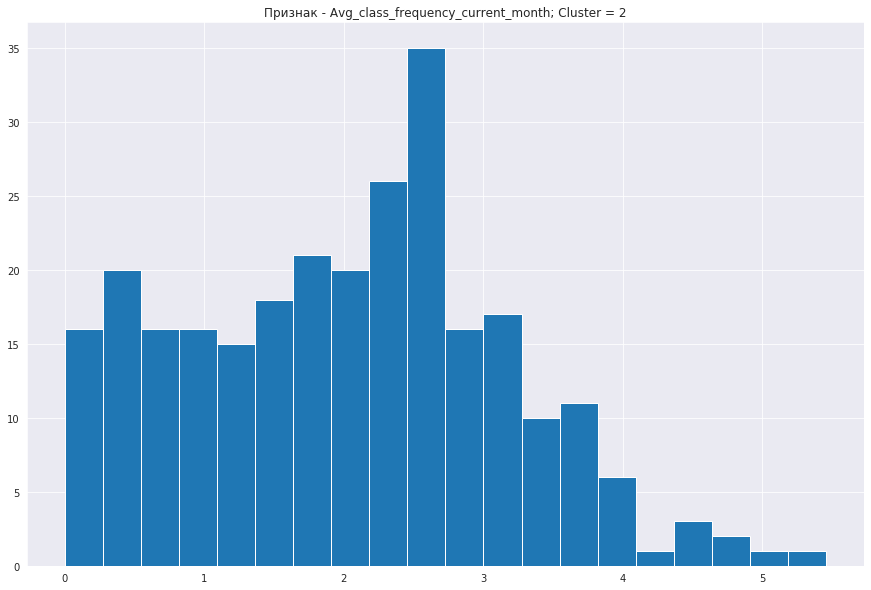

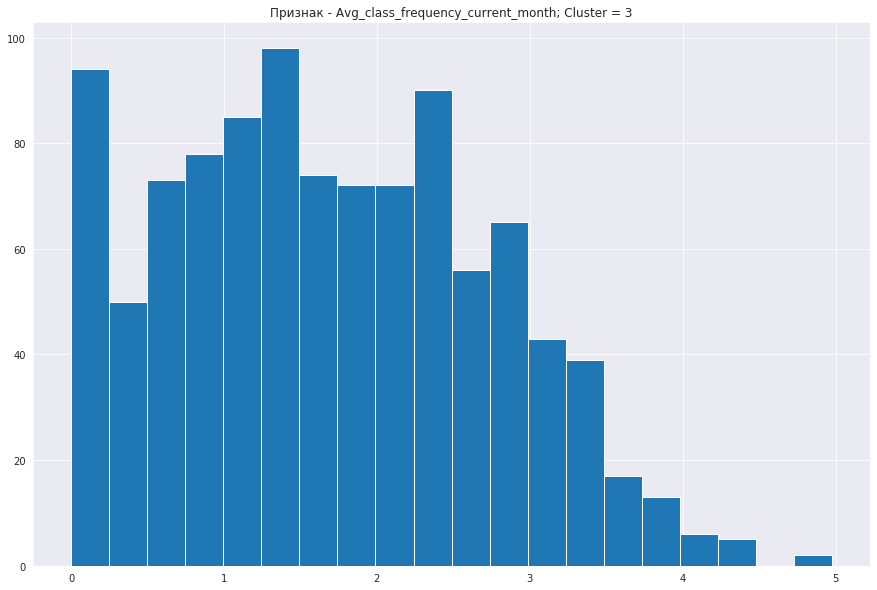

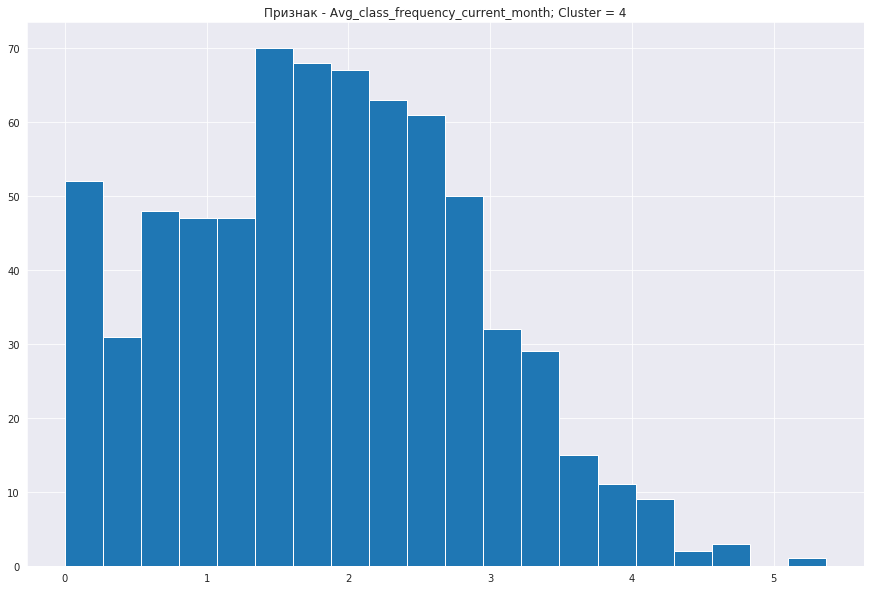

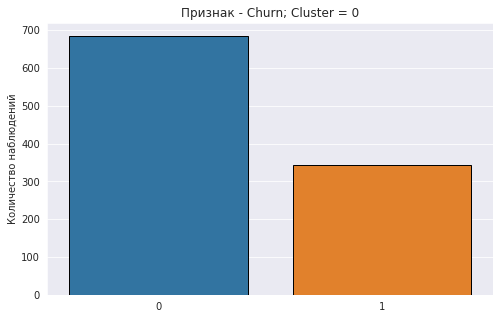

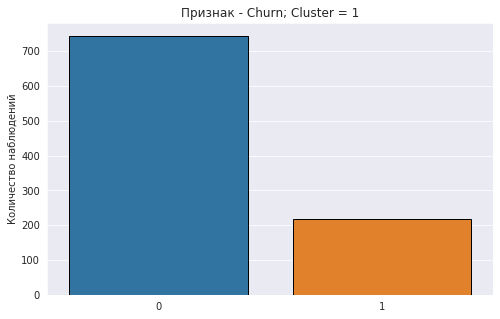

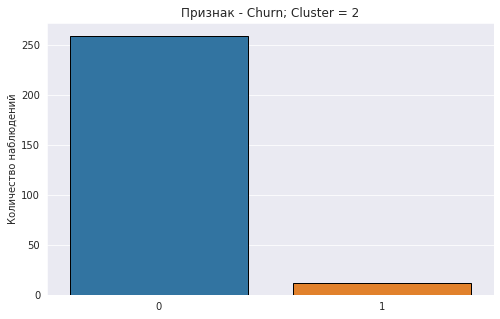

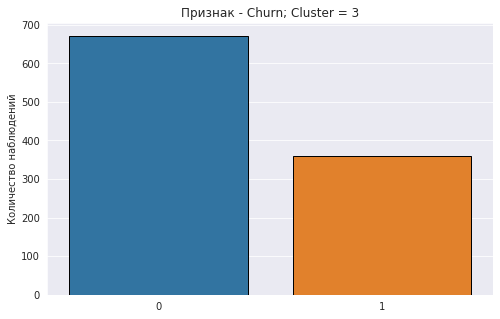

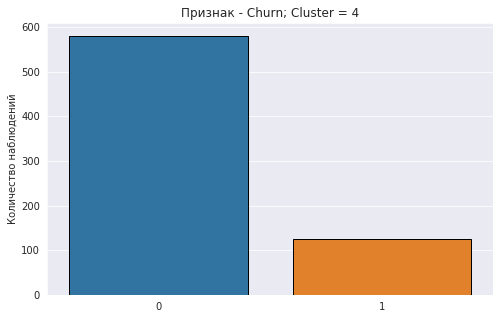

In [42]:
#завернем функцию в цикл и сформируем графики для каждого признака
for column in churn_data.columns:
    if column != 'cluster_km':
        for value in range((churn_data['cluster_km'].max()) + 1):
            feature = 'cluster_km'
            feature_trigger = value
            data = churn_data[[column, 'cluster_km']]
            distribution_graph_drawer(data, feature, feature_trigger, value)

1. По признаку `gender` наблюдается практически идентичная картина во всех кластерах за исключением того, у которого среднее значение Churn наименьшее - то есть, в наиболее лояльной группе немного иная гендерная структура
2. В одной из наименее лояльных групп наблюдается сниженное количество клиентов, чей работодатель является партнеров фитнес-клуба. Вероятно, для определенной аудитории это имеет значение
3. В группах наиболее «лояльных» пользователей наблюдается более высокое количество абонементов на 12 месяцев
4. По признаку `Age` в целом наблюдается паритет. Ядерная аудитория концентрируется у отметки в 30 лет. Однако для более лояльных групп наблюдается небольшое смещение моды вправо - слегка за 30 лет. В то время как менее лояльные кластеры также в среднем моложе
5. Для признака `Avg_additional_charges_total` характерна уже ранее зафиксированная по средним значениям картина - пользователи в лояльных группах склонны тратить больше денег на дополнительные сервисы, предоставляемые клубом. Другими словами, «лояльные» посетители более выгодны нам и в плане генерации дополнительных стримов выручки
6. В целом посетители склонны посещать клуб дважды в неделю, но в лояльных группах это значение даже слегка выше - на уровне 2.5-3 посещений. На этом фоне любопытно, что в наиболее лояльной группе наблюдается сниженное количество пользователей с «длинным» `Lifetime`
7. Аналогичная ситуация с посещаемостью наблюдается и для признака, характеризующего текущий месяц. Чем ниже уровень оттока в кластере, тем сильнее распределение признака для него смещено вправо, что говорит о более высоком уровне посещаемости в группах на момент сбора данных

In [43]:
#соберем небольшой датафрейм, куда запишем номера кластеров, значение признака Churn и доля для признака в кластере
cluster_portions = churn_data.groupby(['cluster_km', 'Churn'], as_index=False).agg({'Age': 'count'}).merge(
churn_data.groupby('cluster_km', as_index=False).agg({'Age': 'count'}), on='cluster_km', how='left')
cluster_portions['portion, %'] = round(((cluster_portions['Age_x'] / cluster_portions['Age_y']) * 100), 2)
cluster_portions = cluster_portions.drop(['Age_x', 'Age_y'], axis = 1)

In [44]:
cluster_portions

,cluster_km,Churn,"portion, %"
0,0,0,66.57
1,0,1,33.43
2,1,0,77.34
3,1,1,22.66
4,2,0,95.57
5,2,1,4.43
6,3,0,65.02
7,3,1,34.98
8,4,0,82.15
9,4,1,17.85


Мы можем наблюдать явные отличия по доле оттока пользователей в разныз кластерах. Для некоторых кластеров это значение превышает 30%, что в 6-7 раз выше аналогичного для кластера наиболее "лояльных" пользователей. 

In [45]:
features.sort_values(by='abs', ascending=False)

,feature,coeff,abs
12,Avg_class_frequency_current_month,-4.189012,4.189012
10,Lifetime,-3.471939,3.471939
11,Avg_class_frequency_total,3.105587,3.105587
7,Age,-1.148928,1.148928
5,Contract_period,-0.687710,0.687710
9,Month_to_end_contract,-0.617235,0.617235
8,Avg_additional_charges_total,-0.560866,0.560866
6,Group_visits,-0.393328,0.393328
3,Promo_friends,-0.139599,0.139599
2,Partner,-0.068231,0.068231


# Выводы и рекомендации

1. При анализе весов коэффициентов логистической регрессии, было установлено, что посещаемость в текущем месяце - это один из самых точных индикаторов того, что клиент вероятно покинет клуб. Значение схожего по смыслу признака - средней посещаемости в целом также имеет большой вес. Это наводит на мысль о том, что эту метрику следует отслеживать крайне внимательно и прикладывать усилия по ее наращиванию - стимулировать приток пользователей:
    - Организовать регулярные "тестирования" какой-нибудь спортивной продукции (протеин, изотоник и т.п.). В качестве возможного варианта можно было бы рассмотреть сотрудничество с маркетинговыми отделами крупных производителей спортивного питания, напитков, одежды
    - Запустить программу лояльности для посетителей с определенным уровнем посещаемости (так, заодно, компенсируется другой возможный фактор оттока - отсутствие партнерской программы с работодателем)
    - Организовать какой-то формат "соревнования" между посетителями клуба - аналог "клубной" социальной сети для посетителей центра 
    - Организовать периодические соревнования/лотереи с призами различнной ценности, раздачей брендированной сувенирной продукции, которые:
        + Помогут сгенерировать приток посетителей в определенные дни и, возможно, улучшить среди них нетворкинг (что поможет нивелировать фактор занятий с партнером) 
        + Помогут привлечь часть не лояльной аудитории обратно в клуб, возможно подкрепить мотивацию
2. Также мы наблюдаем, что значение имеет признак `Lifetime`. Методы его наращивания пересекаются с маркетинговыми активностями, перечисленными в пункте выше. Здесь мы можем сделать допущение о том, что некоторая доля аудитории при пересечении некой "переломной" отметки на временной оси переходит в группу лояльных клиентов (привычка к месту/тренеру/программам, налаживание социальных связей). По этой причине разумным выглядит в дополнение у уже перечисленным мерам рассмотреть опцию со специальными, алгоритмически рассчитанными, ценами для "пограничных" посетителей. Тут требуется:
    - Регулярный мониторинг метрики и сбор данных
    - Анализ данных и обучение модели
    - Выявление когорты "пограничных" пользователей для которых будет подготовлена специальная цена
3. Мы видим, что вес признака `Age` также в первой пятерке. Анализ графиков распределения признаков показал, что в наименее лояльных группах средний возраст ниже 30 лет. Кроме того, для ВСЕХ кластеров мы наблюдаем среднее значение возраста для уходящей аудитории около 27 лет. Рекомендуется:
    - Бенчмаркинг - эта проблема актуальна только для нашего клуба или это общеотраслевая тенденция
        + Если общеотраслевая тенденция, необходимо изучить лучшие практики решения проблемы в отрасли и рассмотреть возможность их внедрения в нашем клубе
        + Если проблема характерна для нашего клуба, то необходимо провести исследование на предмет важных факторов в фитнес-клубе среди более молодой аудитории и далее попробовать внести соответствующие изменения в нашем клубе
    - Как "быструю" меру можно рассмотреть аудит технологичности клуба - вероятно, проблема в том, что в нашем клубе нет того, что востребовано у молодой аудитории (приложение, он-лайн расписание/запись, оплата и т.п.)
    - Необходим аудит оснащения тренажеров и спектра групповых программ - вполне вероятно, что мы не предлагаем "модные" направления (кроссфит, йога, воркаут и т.п.)
4. В процессе изучения данных стало понятно, что некоторая часть пользователей изначально приобретает "короткий" абонемент для пробы и они же не возвращаются в клуб. Рекомендуется организовать отслеживание этого сегмента с применением комбинации мер, приведенных в пунктах выше